### Name: Anushka Chabey
### Roll: ZDA24M012
### Topic: Video Frame Prediction with CNNs

# Import

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Import Dataset

In [3]:

# Specify the path where the dataset is stored
file_path = '/kaggle/input/moving-mnist/mnist_test_seq.npy'   

# Load the dataset
data = np.load(file_path)

# Check the shape of the dataset
print(f'Dataset shape: {data.shape}')
# Normalize and reshape for PyTorch
data = data / 255.0  # Normalize to [0, 1]
data = np.transpose(data, (1, 0, 2, 3)) 
print(f'Transformed Dataset shape: {data.shape}')

Dataset shape: (20, 10000, 64, 64)
Transformed Dataset shape: (10000, 20, 64, 64)


# Loss Function Evaluation

In [3]:
class MovingMNISTDataset2(Dataset):
    def __init__(self, data, t=0, seq_len=10):
        self.data = data
        self.t = t
        self.seq_len = seq_len

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        input_frames = self.data[idx, self.t:self.t + self.seq_len]        # frames t to t+9
        target_frame = self.data[idx, self.t + self.seq_len]               # frame t+10
        input_tensor = torch.tensor(input_frames, dtype=torch.float32)     # shape (10, 64, 64)
        target_tensor = torch.tensor(target_frame, dtype=torch.float32).unsqueeze(0)
        return input_tensor, target_tensor


In [4]:
class VanillaCNN2(nn.Module):
    def __init__(self):
        super(VanillaCNN2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(10, 32, 3, padding=1), nn.ReLU(),  
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [5]:
dataset1 = MovingMNISTDataset2(data, t=0, seq_len=10)
dataloader = DataLoader(dataset1, batch_size=64, shuffle=True)

In [8]:
pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 2.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found

In [9]:
from tqdm import tqdm  # Add this import
# Model, loss, optimizer
model_23 = VanillaCNN2()

def custom_loss(pred, target): 
    mse = nn.MSELoss()(pred, target)
    l1 = nn.L1Loss()(pred, target)
    return 0.5 * mse + 0.5 * l1

from piq import ssim
def ssim_loss(pred, target): 
    mse = nn.MSELoss()(pred, target)
    ssim_val = ssim(pred, target, data_range=1.)
    return 0.7 * mse + 0.3 * (1 - ssim_val)
import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()
        
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets):
        # bce_loss = self.bce(inputs, targets)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - ((2. * intersection + 1) / (inputs.sum() + targets.sum() + 1))
        # return bce_loss + dice_loss
        return dice_loss
        

# criterion = BCEDiceLoss() # Combines BCE and Dice Loss — good for structure and reducing class imbalance.
# criterion = FocalLoss()   # Focuses on hard-to-predict pixels — effective for class imbalance.
criterion = nn.BCELoss()  # Binary Cross-Entropy — works well with sigmoid output and normalized [0,1] data.
# criterion = nn.L1Loss()   # L1 Loss (MAE) — preserves edges better, less sensitive to outliers than MSE.
# criterion = nn.MSELoss()  # Mean Squared Error — smooths predictions but may blur details in images.



# criterion = nn.SmoothL1Loss() # 4. Smooth L1 Loss (Huber Loss) — balances L1 and MSE, more robust to outliers
# criterion = custom_loss # 5. Combined MSE + L1 (custom loss) — simple hybrid
# criterion = ssim_loss # 6. MSE + SSIM (perceptual quality) — requires 'piq' package
# criterion = FocalLoss()


optimizer = optim.Adam(model_23.parameters(), lr=0.001)

# Train
for epoch in range(20):
    total_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    
    for x, y in loop:
        optimizer.zero_grad()
        output = model_23(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Update tqdm description with current loss
        loop.set_postfix(loss=loss.item())
    
    print(f"Epoch {epoch+1} Average Loss: {total_loss / len(dataloader):.4f}")


Epoch 1: 100%|██████████| 157/157 [04:13<00:00,  1.61s/it, loss=0.0935]


Epoch 1 Average Loss: 0.1952


Epoch 2: 100%|██████████| 157/157 [04:12<00:00,  1.61s/it, loss=0.0814]


Epoch 2 Average Loss: 0.0862


Epoch 3: 100%|██████████| 157/157 [04:29<00:00,  1.72s/it, loss=0.0806]


Epoch 3 Average Loss: 0.0829


Epoch 4: 100%|██████████| 157/157 [04:18<00:00,  1.65s/it, loss=0.0932]


Epoch 4 Average Loss: 0.0813


Epoch 5: 100%|██████████| 157/157 [04:35<00:00,  1.75s/it, loss=0.0725]


Epoch 5 Average Loss: 0.0797


Epoch 6: 100%|██████████| 157/157 [04:27<00:00,  1.70s/it, loss=0.0772]


Epoch 6 Average Loss: 0.0784


Epoch 7: 100%|██████████| 157/157 [04:45<00:00,  1.82s/it, loss=0.0767]


Epoch 7 Average Loss: 0.0772


Epoch 8: 100%|██████████| 157/157 [04:27<00:00,  1.70s/it, loss=0.0799]


Epoch 8 Average Loss: 0.0761


Epoch 9: 100%|██████████| 157/157 [04:11<00:00,  1.60s/it, loss=0.0737]


Epoch 9 Average Loss: 0.0753


Epoch 10: 100%|██████████| 157/157 [04:29<00:00,  1.71s/it, loss=0.0659]


Epoch 10 Average Loss: 0.0745


Epoch 11: 100%|██████████| 157/157 [04:14<00:00,  1.62s/it, loss=0.0768]


Epoch 11 Average Loss: 0.0740


Epoch 12: 100%|██████████| 157/157 [04:14<00:00,  1.62s/it, loss=0.0741]


Epoch 12 Average Loss: 0.0734


Epoch 13: 100%|██████████| 157/157 [04:33<00:00,  1.74s/it, loss=0.0744]


Epoch 13 Average Loss: 0.0729


Epoch 14: 100%|██████████| 157/157 [04:13<00:00,  1.62s/it, loss=0.0711]


Epoch 14 Average Loss: 0.0722


Epoch 15: 100%|██████████| 157/157 [04:31<00:00,  1.73s/it, loss=0.0711]


Epoch 15 Average Loss: 0.0718


Epoch 16: 100%|██████████| 157/157 [04:12<00:00,  1.61s/it, loss=0.0667]


Epoch 16 Average Loss: 0.0714


Epoch 17: 100%|██████████| 157/157 [04:28<00:00,  1.71s/it, loss=0.0696]


Epoch 17 Average Loss: 0.0709


Epoch 18: 100%|██████████| 157/157 [04:16<00:00,  1.63s/it, loss=0.0695]


Epoch 18 Average Loss: 0.0705


Epoch 19: 100%|██████████| 157/157 [04:14<00:00,  1.62s/it, loss=0.0612]


Epoch 19 Average Loss: 0.0702


Epoch 20: 100%|██████████| 157/157 [04:33<00:00,  1.74s/it, loss=0.0693]

Epoch 20 Average Loss: 0.0699


In [13]:
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F
from tqdm import tqdm 

model_23.eval()
total_loss = 0
total_ssim = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in tqdm(dataloader, desc="Evaluating", unit="batch"):
        # Shape: [B, 10, 28, 28] → [B, 1, 28, 28]
        preds = model_23(inputs)

        # Ensure shape match for BCE or Dice
        if preds.ndim == 3:
            preds = preds.unsqueeze(1)
        if targets.ndim == 3:
            targets = targets.unsqueeze(1)

        # Compute loss
        loss = BCEDiceLoss()(preds, targets)
        total_loss += loss.item()

        # Compute SSIM batch-wise
        batch_ssim = 0
        for i in range(preds.size(0)):
            pred_img = preds[i].squeeze().cpu().numpy()
            true_img = targets[i].squeeze().cpu().numpy()
            batch_ssim += ssim(pred_img, true_img, data_range=1.0)
        total_ssim += batch_ssim / preds.size(0)

        num_batches += 1

avg_loss = total_loss / num_batches
avg_ssim = total_ssim / num_batches

print(f"\n🧪 Average Test Loss: {avg_loss:.4f}")
print(f"📷 Average SSIM: {avg_ssim:.4f}")


Evaluating: 100%|██████████| 157/157 [01:48<00:00,  1.44batch/s]


🧪 Average Test Loss: 0.4720
📷 Average SSIM: 0.8250


In [42]:
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F
from tqdm import tqdm 

model_21.eval()
total_loss = 0
total_ssim = 0
num_batches = 0

with torch.no_grad():
    for inputs, targets in tqdm(dataloader, desc="Evaluating", unit="batch"):
        # Shape: [B, 10, 28, 28] → [B, 1, 28, 28]
        preds = model_21(inputs)

        # Ensure shape match for BCE or Dice
        if preds.ndim == 3:
            preds = preds.unsqueeze(1)
        if targets.ndim == 3:
            targets = targets.unsqueeze(1)

        # Compute loss
        loss = BCEDiceLoss()(preds, targets)
        total_loss += loss.item()

        # Compute SSIM batch-wise
        batch_ssim = 0
        for i in range(preds.size(0)):
            pred_img = preds[i].squeeze().cpu().numpy()
            true_img = targets[i].squeeze().cpu().numpy()
            batch_ssim += ssim(pred_img, true_img, data_range=1.0)
        total_ssim += batch_ssim / preds.size(0)

        num_batches += 1

avg_loss = total_loss / num_batches
avg_ssim = total_ssim / num_batches

print(f"\n🧪 Average Test Loss: {avg_loss:.4f}")
print(f"📷 Average SSIM: {avg_ssim:.4f}")


Evaluating: 100%|██████████| 157/157 [01:48<00:00,  1.44batch/s]


🧪 Average Test Loss: 0.3329
📷 Average SSIM: 0.8687


index of image in dataset: 4869
torch.Size([10, 64, 64]) torch.Size([1, 10, 64, 64])


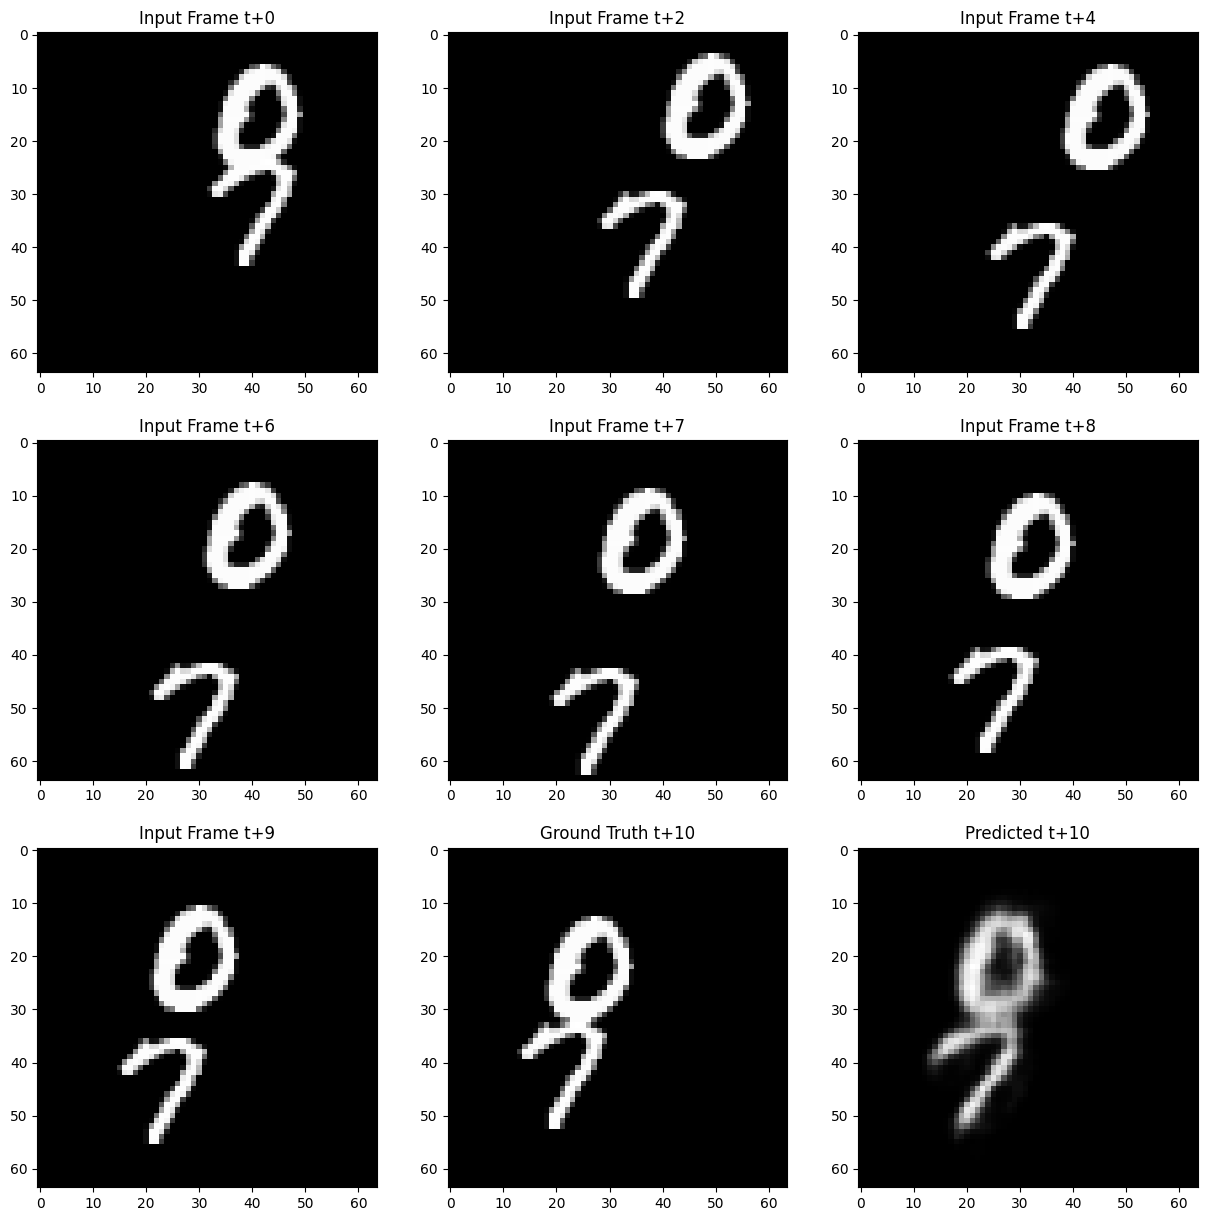

In [12]:
import random
r=random.randint(0,10000)
print(f'index of image in dataset: {r}')

# 255, 532
test_x, test_y = dataset1[255]
test_x = test_x.unsqueeze(0)
model_23.eval()
with torch.no_grad():
    pred_y = model_23(test_x)

if pred_y.ndim == 3:
    pred_y_modified = pred_y.unsqueeze(1) 
    test_y_modified=test_y
if test_y.ndim == 3:
    test_y_modified = test_y.unsqueeze(1)
    pred_y_modified=pred_y
# ssim_val = ssim(pred_y_modified, test_y_modified, data_range=1.)
# print(f'Structural Similarity Index: {ssim_val}')

print(test_x.squeeze(0).size(), test_x.size())

plt.figure(figsize=(15, 15))  # Wider figure
for idx, i in enumerate([0,2,4,6,7,8,9,'test','pred']):
    plt.subplot(3, 3, 1+idx)
    if i=='test':
        plt.imshow(test_y.squeeze(), cmap='gray')
        plt.title("Ground Truth t+10")
    elif i == 'pred':
        plt.imshow(pred_y.squeeze(), cmap='gray')
        plt.title("Predicted t+10")
    else:
        plt.imshow(test_x.squeeze(0)[i], cmap='gray')
        plt.title(f"Input Frame t+{i}")



# Results: Loss Function Evaluation
model_1: bce, 1 epoch <br>
model_2: bce, 5 epoch <br>
model_3: l1, 1 epoch Blank <br>
model_4: FocalLoss, 1 epoch <br>
model_5: BCEDiceLoss, 1 epoch <br>
model_6: BCEDiceLoss, 5 epoch

model_21: BCEDiceloss: 20 epoch <br>
model_22: Diceloss: 20 epoch 

# Multiple-Frame Prediction

In [34]:
class MovingMNISTMultiFrameDataset(Dataset):
    def __init__(self, data, t=0, input_len=10, pred_len=5):
        self.data = data
        self.t = t
        self.input_len = input_len
        self.pred_len = pred_len

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        input_frames = self.data[idx, self.t:self.t + self.input_len]              # (10, 64, 64)
        target_frames = self.data[idx, self.t + self.input_len:self.t + self.input_len + self.pred_len]  # (5, 64, 64)
        input_tensor = torch.tensor(input_frames, dtype=torch.float32)
        target_tensor = torch.tensor(target_frames, dtype=torch.float32)           # (5, 64, 64)
        return input_tensor, target_tensor
class VanillaCNNMultiDecoder(nn.Module):
    def __init__(self, pred_len=5):
        super(VanillaCNNMultiDecoder, self).__init__()
        self.pred_len = pred_len
        self.encoder = nn.Sequential(
            nn.Conv2d(10, 32, 3, padding=1), nn.ReLU(),  
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.Conv2d(32, pred_len, 3, padding=1), nn.Sigmoid()  # Output 5 channels (frames)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x  # shape: (B, 5, 64, 64)
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet18MultiDecoder(nn.Module):
    def __init__(self, pred_len=5):
        super(ResNet18MultiDecoder, self).__init__()
        self.pred_len = pred_len
        
        resnet = models.resnet18(weights=None)  
        self.encoder = resnet
        
        self.encoder.conv1 = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.encoder = nn.Sequential(
            self.encoder.conv1,
            self.encoder.bn1,
            self.encoder.relu,
            self.encoder.maxpool,
            self.encoder.layer1,
            self.encoder.layer2,
            self.encoder.layer3,
            self.encoder.layer4
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, pred_len, kernel_size=2, stride=2), nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.encoder(x)           
        x = self.decoder(x)
        return x


## CNN: Multiple Frame Prediction

In [10]:
from tqdm import tqdm
# Dataset and Dataloader
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = MovingMNISTMultiFrameDataset(data, t=0, input_len=10, pred_len=5)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model
model = VanillaCNNMultiDecoder(pred_len=5).to(device)
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - ((2. * intersection + 1) / (inputs.sum() + targets.sum() + 1))
        return bce_loss + dice_loss
# Criterion & Optimizer
criterion = nn.BCELoss()  # or any of your defined losses
# criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(20):
    total_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    
    for x, y in loop:
        x = x.unsqueeze(1).to(device)  # shape: (B, 1, 10, 64, 64)
        y = y.to(device)

        # Collapse time dim into channel dim for CNN (reshape to (B, 10, 64, 64))
        x = x.view(x.size(0), 10, 64, 64)
        
        optimizer.zero_grad()
        output = model(x)  # shape: (B, 5, 64, 64)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    
    print(f"Epoch {epoch+1} Average Loss: {total_loss / len(dataloader):.4f}")


Using device: cuda


Epoch 1: 100%|██████████| 157/157 [00:06<00:00, 23.01it/s, loss=0.156]


Epoch 1 Average Loss: 0.2323


Epoch 2: 100%|██████████| 157/157 [00:06<00:00, 23.29it/s, loss=0.143]


Epoch 2 Average Loss: 0.1447


Epoch 3: 100%|██████████| 157/157 [00:06<00:00, 23.07it/s, loss=0.136]


Epoch 3 Average Loss: 0.1400


Epoch 4: 100%|██████████| 157/157 [00:06<00:00, 22.92it/s, loss=0.133]


Epoch 4 Average Loss: 0.1384


Epoch 5: 100%|██████████| 157/157 [00:06<00:00, 22.84it/s, loss=0.142]


Epoch 5 Average Loss: 0.1373


Epoch 6: 100%|██████████| 157/157 [00:06<00:00, 22.60it/s, loss=0.13] 


Epoch 6 Average Loss: 0.1364


Epoch 7: 100%|██████████| 157/157 [00:06<00:00, 23.03it/s, loss=0.131]


Epoch 7 Average Loss: 0.1357


Epoch 8: 100%|██████████| 157/157 [00:06<00:00, 23.11it/s, loss=0.14] 


Epoch 8 Average Loss: 0.1351


Epoch 9: 100%|██████████| 157/157 [00:06<00:00, 23.17it/s, loss=0.125]


Epoch 9 Average Loss: 0.1344


Epoch 10: 100%|██████████| 157/157 [00:06<00:00, 23.23it/s, loss=0.132]


Epoch 10 Average Loss: 0.1339


Epoch 11: 100%|██████████| 157/157 [00:06<00:00, 23.32it/s, loss=0.129]


Epoch 11 Average Loss: 0.1333


Epoch 12: 100%|██████████| 157/157 [00:06<00:00, 22.83it/s, loss=0.13] 


Epoch 12 Average Loss: 0.1333


Epoch 13: 100%|██████████| 157/157 [00:06<00:00, 23.34it/s, loss=0.131]


Epoch 13 Average Loss: 0.1327


Epoch 14: 100%|██████████| 157/157 [00:06<00:00, 23.21it/s, loss=0.127]


Epoch 14 Average Loss: 0.1325


Epoch 15: 100%|██████████| 157/157 [00:06<00:00, 23.06it/s, loss=0.128]


Epoch 15 Average Loss: 0.1321


Epoch 16: 100%|██████████| 157/157 [00:06<00:00, 23.05it/s, loss=0.128]


Epoch 16 Average Loss: 0.1319


Epoch 17: 100%|██████████| 157/157 [00:06<00:00, 22.86it/s, loss=0.136]


Epoch 17 Average Loss: 0.1316


Epoch 18: 100%|██████████| 157/157 [00:06<00:00, 23.13it/s, loss=0.127]


Epoch 18 Average Loss: 0.1313


Epoch 19: 100%|██████████| 157/157 [00:06<00:00, 22.97it/s, loss=0.123]


Epoch 19 Average Loss: 0.1310


Epoch 20: 100%|██████████| 157/157 [00:06<00:00, 23.00it/s, loss=0.122]


Epoch 20 Average Loss: 0.1308


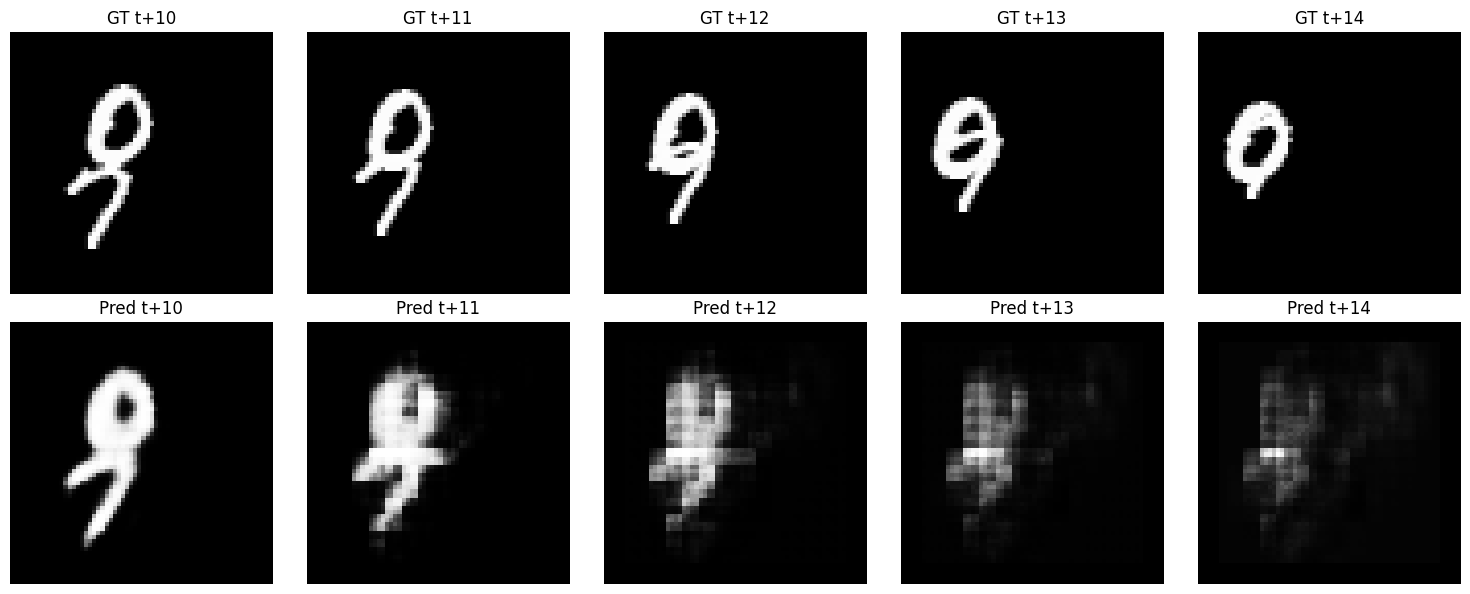

In [8]:
# Inference
test_x, test_y = dataset[255]
test_x = test_x.unsqueeze(0)  # Add batch dim

device = next(model.parameters()).device  # Get model's device (CPU or CUDA)
test_x = test_x.to(device)  
test_y = test_y.to(device)

model.eval()
with torch.no_grad():
    pred_y = model(test_x)  # Output shape: (1, 5, 64, 64)

# Visualization
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_y[i].cpu(), cmap='gray')  # Move to CPU for plotting
    plt.title(f"GT t+{10+i}")
    plt.axis('off')
    
    plt.subplot(2, 5, i + 6)
    plt.imshow(pred_y[0, i].cpu(), cmap='gray')  # Move to CPU for plotting
    plt.title(f"Pred t+{10+i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F
from tqdm import tqdm
import torch
import torch.nn as nn  # <-- Add this import

model.eval()
total_loss = 0.0
total_ssim = 0.0
num_batches = 0

device = next(model.parameters()).device

with torch.no_grad():
    for inputs, targets in tqdm(dataloader, desc="Evaluating", unit="batch"):
        inputs, targets = inputs.to(device), targets.to(device)
        preds = model(inputs)

        if preds.ndim == 3:
            preds = preds.unsqueeze(1)
        if targets.ndim == 3:
            targets = targets.unsqueeze(1)

        loss = nn.BCELoss()(preds, targets)
        # loss = BCEDiceLoss()(preds, targets)
        
        total_loss += loss.item()

        batch_ssim = 0.0
        for i in range(preds.size(0)):
            pred_img = preds[i].detach().cpu().squeeze().numpy()
            true_img = targets[i].detach().cpu().squeeze().numpy()

            # Ensure 2D shape
            if pred_img.ndim == 3:
                pred_img = pred_img[0]
            if true_img.ndim == 3:
                true_img = true_img[0]

            h, w = pred_img.shape
            win_size = min(h, w)
            if win_size % 2 == 0:
                win_size -= 1  # Ensure win_size is odd and fits image size

            batch_ssim += ssim(pred_img, true_img, data_range=1.0, win_size=win_size)

        total_ssim += batch_ssim / preds.size(0)
        num_batches += 1

avg_loss = total_loss / num_batches
avg_ssim = total_ssim / num_batches

print(f"\n🧪 Average Test Loss: {avg_loss:.4f}")
print(f"📷 Average SSIM: {avg_ssim:.4f}")


Evaluating: 100%|██████████| 157/157 [00:10<00:00, 15.10batch/s]


🧪 Average Test Loss: 0.7868
📷 Average SSIM: 0.6619


## ResNet: Multiple Frame Prediction

In [ ]:
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

# Assuming dataset and model class have already been defined and imported
dataset = MovingMNISTMultiFrameDataset(data, t=0, input_len=10, pred_len=5)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model
model2 = ResNet18MultiDecoder(pred_len=5)
model2 = model2.to('cuda' if torch.cuda.is_available() else 'cpu')

# Criterion & Optimizer
criterion = nn.BCELoss()
# criterion = BCEDiceLoss()

optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Training Loop
for epoch in range(20):
    model2.train()
    total_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    
    for x, y in loop:
        device = next(model2.parameters()).device
        x, y = x.to(device), y.to(device)

        # x, y = x.to(model2.device), y.to(model2.device)  # Ensure tensors are on the right device
        optimizer.zero_grad()
        output = model2(x)  # Output: (B, 5, 64, 64)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Average Loss: {total_loss / len(dataloader):.4f}")


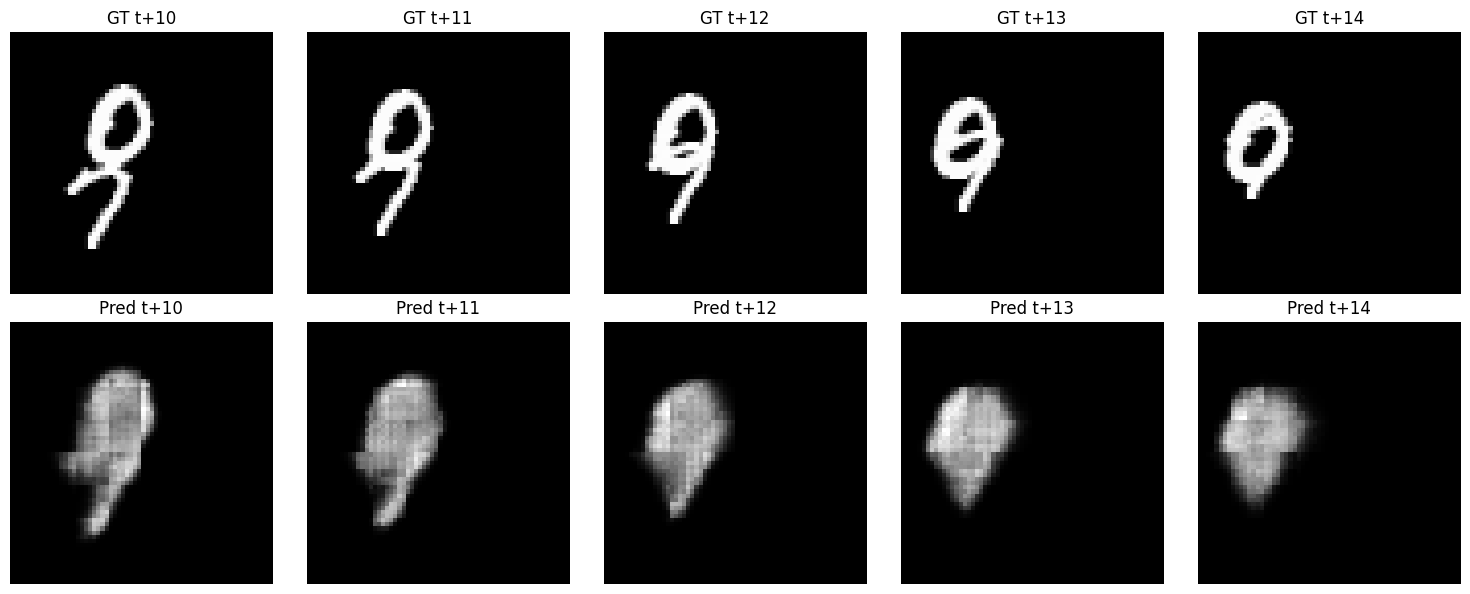

In [13]:
# Inference
test_x, test_y = dataset[255]
test_x = test_x.unsqueeze(0)  # Add batch dim

device = next(model2.parameters()).device  # Get model's device (CPU or CUDA)
test_x = test_x.to(device)  
test_y = test_y.to(device)

model2.eval()
with torch.no_grad():
    pred_y = model2(test_x)  # Output shape: (1, 5, 64, 64)

# Visualization
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_y[i].cpu(), cmap='gray')  # Move to CPU for plotting
    plt.title(f"GT t+{10+i}")
    plt.axis('off')
    
    plt.subplot(2, 5, i + 6)
    plt.imshow(pred_y[0, i].cpu(), cmap='gray')  # Move to CPU for plotting
    plt.title(f"Pred t+{10+i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F
from tqdm import tqdm
import torch
import torch.nn as nn  # <-- Add this import

model2.eval()
total_loss = 0.0
total_ssim = 0.0
num_batches = 0

device = next(model2.parameters()).device

with torch.no_grad():
    for inputs, targets in tqdm(dataloader, desc="Evaluating", unit="batch"):
        inputs, targets = inputs.to(device), targets.to(device)
        preds = model2(inputs)

        if preds.ndim == 3:
            preds = preds.unsqueeze(1)
        if targets.ndim == 3:
            targets = targets.unsqueeze(1)

        loss = nn.BCELoss()(preds, targets)
        # loss = BCEDiceLoss()(preds,targets)
        
        total_loss += loss.item()

        batch_ssim = 0.0
        for i in range(preds.size(0)):
            pred_img = preds[i].detach().cpu().squeeze().numpy()
            true_img = targets[i].detach().cpu().squeeze().numpy()

            # Ensure 2D shape
            if pred_img.ndim == 3:
                pred_img = pred_img[0]
            if true_img.ndim == 3:
                true_img = true_img[0]

            h, w = pred_img.shape
            win_size = min(h, w)
            if win_size % 2 == 0:
                win_size -= 1  # Ensure win_size is odd and fits image size

            batch_ssim += ssim(pred_img, true_img, data_range=1.0, win_size=win_size)

        total_ssim += batch_ssim / preds.size(0)
        num_batches += 1

avg_loss = total_loss / num_batches
avg_ssim = total_ssim / num_batches

print(f"\n🧪 Average Test Loss: {avg_loss:.4f}")
print(f"📷 Average SSIM: {avg_ssim:.4f}")


Evaluating: 100%|██████████| 157/157 [00:10<00:00, 15.23batch/s]


🧪 Average Test Loss: 0.0769
📷 Average SSIM: 0.7089


# Recursive Prediction in Testing

In [24]:
class MovingMNISTDataset4(Dataset):
    def __init__(self, data, t=0, seq_len=10):
        self.data = data
        self.t = t
        self.seq_len = seq_len

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        input_frames = self.data[idx, self.t:self.t + self.seq_len]        # frames t to t+9
        target_frame = self.data[idx, self.t + self.seq_len]               # frame t+10
        input_tensor = torch.tensor(input_frames, dtype=torch.float32)     # shape (10, 64, 64)
        target_tensor = torch.tensor(target_frame, dtype=torch.float32).unsqueeze(0)
        return input_tensor, target_tensor
class VanillaCNN4(nn.Module):
    def __init__(self):
        super(VanillaCNN4, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(10, 32, 3, padding=1), nn.ReLU(),  
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

import torch
import torch.nn as nn
import torchvision.models as models

class ResNet18_v4(nn.Module):
    def __init__(self):
        super(ResNet18_v4, self).__init__()
        resnet = models.resnet18(weights=None)  
        self.encoder = resnet
        
        self.encoder.conv1 = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.encoder = nn.Sequential(
            self.encoder.conv1,
            self.encoder.bn1,
            self.encoder.relu,
            self.encoder.maxpool,
            self.encoder.layer1,
            self.encoder.layer2,
            self.encoder.layer3,
            self.encoder.layer4
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2), nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.encoder(x)           
        x = self.decoder(x)
        return x



In [25]:
dataset4 = MovingMNISTDataset4(data, t=0, seq_len=10)
dataloader = DataLoader(dataset4, batch_size=64, shuffle=True)

## Change model to test for CNN and ResNet

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model_42 = ResNet18_v4()
model_42 = model_42.to(device)
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - ((2. * intersection + 1) / (inputs.sum() + targets.sum() + 1))
        return bce_loss + dice_loss
# criterion = nn.BCELoss() 
criterion = BCEDiceLoss()  

optimizer = optim.Adam(model_42.parameters(), lr=0.001)

Using device: cuda


In [27]:
from tqdm import tqdm  

    
for epoch in range(100):
    total_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    
    for x, y in loop:
        x = x.to(device)  # shape: (B, 1, 10, 64, 64)
        y = y.to(device)
        optimizer.zero_grad()
        output = model_42(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())
    
    print(f"Epoch {epoch+1} Average Loss: {total_loss / len(dataloader):.4f}")


Epoch 1: 100%|██████████| 157/157 [00:06<00:00, 24.27it/s, loss=0.647]


Epoch 1 Average Loss: 0.7898


Epoch 2: 100%|██████████| 157/157 [00:06<00:00, 24.74it/s, loss=0.626]


Epoch 2 Average Loss: 0.5954


Epoch 3: 100%|██████████| 157/157 [00:06<00:00, 24.69it/s, loss=0.501]


Epoch 3 Average Loss: 0.5537


Epoch 4: 100%|██████████| 157/157 [00:06<00:00, 24.72it/s, loss=0.535]


Epoch 4 Average Loss: 0.5234


Epoch 5: 100%|██████████| 157/157 [00:06<00:00, 24.46it/s, loss=0.513]


Epoch 5 Average Loss: 0.4990


Epoch 6: 100%|██████████| 157/157 [00:06<00:00, 24.37it/s, loss=0.429]


Epoch 6 Average Loss: 0.4758


Epoch 7: 100%|██████████| 157/157 [00:06<00:00, 24.20it/s, loss=0.424]


Epoch 7 Average Loss: 0.4574


Epoch 8: 100%|██████████| 157/157 [00:06<00:00, 24.08it/s, loss=0.44] 


Epoch 8 Average Loss: 0.4404


Epoch 9: 100%|██████████| 157/157 [00:06<00:00, 24.06it/s, loss=0.441]


Epoch 9 Average Loss: 0.4257


Epoch 10: 100%|██████████| 157/157 [00:06<00:00, 24.26it/s, loss=0.408]


Epoch 10 Average Loss: 0.4096


Epoch 11: 100%|██████████| 157/157 [00:06<00:00, 24.27it/s, loss=0.396]


Epoch 11 Average Loss: 0.3979


Epoch 12: 100%|██████████| 157/157 [00:06<00:00, 24.68it/s, loss=0.377]


Epoch 12 Average Loss: 0.3847


Epoch 13: 100%|██████████| 157/157 [00:06<00:00, 24.70it/s, loss=0.402]


Epoch 13 Average Loss: 0.3734


Epoch 14: 100%|██████████| 157/157 [00:06<00:00, 24.60it/s, loss=0.383]


Epoch 14 Average Loss: 0.3647


Epoch 15: 100%|██████████| 157/157 [00:06<00:00, 24.67it/s, loss=0.345]


Epoch 15 Average Loss: 0.3530


Epoch 16: 100%|██████████| 157/157 [00:06<00:00, 24.66it/s, loss=0.361]


Epoch 16 Average Loss: 0.3434


Epoch 17: 100%|██████████| 157/157 [00:06<00:00, 24.50it/s, loss=0.341]


Epoch 17 Average Loss: 0.3341


Epoch 18: 100%|██████████| 157/157 [00:06<00:00, 24.71it/s, loss=0.321]


Epoch 18 Average Loss: 0.3262


Epoch 19: 100%|██████████| 157/157 [00:06<00:00, 24.59it/s, loss=0.341]


Epoch 19 Average Loss: 0.3187


Epoch 20: 100%|██████████| 157/157 [00:06<00:00, 24.66it/s, loss=0.301]


Epoch 20 Average Loss: 0.3121


Epoch 21: 100%|██████████| 157/157 [00:06<00:00, 24.25it/s, loss=0.296]


Epoch 21 Average Loss: 0.3049


Epoch 22: 100%|██████████| 157/157 [00:06<00:00, 24.51it/s, loss=0.324]


Epoch 22 Average Loss: 0.2998


Epoch 23: 100%|██████████| 157/157 [00:06<00:00, 24.70it/s, loss=0.289]


Epoch 23 Average Loss: 0.2941


Epoch 24: 100%|██████████| 157/157 [00:06<00:00, 24.47it/s, loss=0.292]


Epoch 24 Average Loss: 0.2886


Epoch 25: 100%|██████████| 157/157 [00:06<00:00, 24.48it/s, loss=0.272]


Epoch 25 Average Loss: 0.2833


Epoch 26: 100%|██████████| 157/157 [00:06<00:00, 24.45it/s, loss=0.302]


Epoch 26 Average Loss: 0.2787


Epoch 27: 100%|██████████| 157/157 [00:06<00:00, 24.57it/s, loss=0.268]


Epoch 27 Average Loss: 0.2741


Epoch 28: 100%|██████████| 157/157 [00:06<00:00, 24.56it/s, loss=0.293]


Epoch 28 Average Loss: 0.2702


Epoch 29: 100%|██████████| 157/157 [00:06<00:00, 24.57it/s, loss=0.26] 


Epoch 29 Average Loss: 0.2669


Epoch 30: 100%|██████████| 157/157 [00:06<00:00, 24.57it/s, loss=0.271]


Epoch 30 Average Loss: 0.2634


Epoch 31: 100%|██████████| 157/157 [00:06<00:00, 24.56it/s, loss=0.28] 


Epoch 31 Average Loss: 0.2594


Epoch 32: 100%|██████████| 157/157 [00:06<00:00, 24.69it/s, loss=0.261]


Epoch 32 Average Loss: 0.2554


Epoch 33: 100%|██████████| 157/157 [00:06<00:00, 24.61it/s, loss=0.271]


Epoch 33 Average Loss: 0.2533


Epoch 34: 100%|██████████| 157/157 [00:06<00:00, 24.66it/s, loss=0.257]


Epoch 34 Average Loss: 0.2501


Epoch 35: 100%|██████████| 157/157 [00:06<00:00, 24.62it/s, loss=0.27] 


Epoch 35 Average Loss: 0.2473


Epoch 36: 100%|██████████| 157/157 [00:06<00:00, 24.51it/s, loss=0.246]


Epoch 36 Average Loss: 0.2452


Epoch 37: 100%|██████████| 157/157 [00:06<00:00, 24.75it/s, loss=0.237]


Epoch 37 Average Loss: 0.2427


Epoch 38: 100%|██████████| 157/157 [00:06<00:00, 24.57it/s, loss=0.255]


Epoch 38 Average Loss: 0.2408


Epoch 39: 100%|██████████| 157/157 [00:06<00:00, 24.66it/s, loss=0.241]


Epoch 39 Average Loss: 0.2376


Epoch 40: 100%|██████████| 157/157 [00:06<00:00, 24.70it/s, loss=0.239]


Epoch 40 Average Loss: 0.2369


Epoch 41: 100%|██████████| 157/157 [00:06<00:00, 24.43it/s, loss=0.243]


Epoch 41 Average Loss: 0.2346


Epoch 42: 100%|██████████| 157/157 [00:06<00:00, 24.65it/s, loss=0.236]


Epoch 42 Average Loss: 0.2327


Epoch 43: 100%|██████████| 157/157 [00:06<00:00, 24.71it/s, loss=0.212]


Epoch 43 Average Loss: 0.2297


Epoch 44: 100%|██████████| 157/157 [00:06<00:00, 24.69it/s, loss=0.243]


Epoch 44 Average Loss: 0.2283


Epoch 45: 100%|██████████| 157/157 [00:06<00:00, 24.60it/s, loss=0.231]


Epoch 45 Average Loss: 0.2271


Epoch 46: 100%|██████████| 157/157 [00:06<00:00, 24.53it/s, loss=0.236]


Epoch 46 Average Loss: 0.2250


Epoch 47: 100%|██████████| 157/157 [00:06<00:00, 24.39it/s, loss=0.241]


Epoch 47 Average Loss: 0.2232


Epoch 48: 100%|██████████| 157/157 [00:06<00:00, 24.76it/s, loss=0.224]


Epoch 48 Average Loss: 0.2226


Epoch 49: 100%|██████████| 157/157 [00:06<00:00, 24.55it/s, loss=0.195]


Epoch 49 Average Loss: 0.2204


Epoch 50: 100%|██████████| 157/157 [00:06<00:00, 24.63it/s, loss=0.226]


Epoch 50 Average Loss: 0.2185


Epoch 51: 100%|██████████| 157/157 [00:06<00:00, 24.27it/s, loss=0.217]


Epoch 51 Average Loss: 0.2171


Epoch 52: 100%|██████████| 157/157 [00:06<00:00, 24.61it/s, loss=0.223]


Epoch 52 Average Loss: 0.2158


Epoch 53: 100%|██████████| 157/157 [00:06<00:00, 24.69it/s, loss=0.217]


Epoch 53 Average Loss: 0.2140


Epoch 54: 100%|██████████| 157/157 [00:06<00:00, 24.66it/s, loss=0.238]


Epoch 54 Average Loss: 0.2138


Epoch 55: 100%|██████████| 157/157 [00:06<00:00, 24.52it/s, loss=0.213]


Epoch 55 Average Loss: 0.2131


Epoch 56: 100%|██████████| 157/157 [00:06<00:00, 24.45it/s, loss=0.209]


Epoch 56 Average Loss: 0.2118


Epoch 57: 100%|██████████| 157/157 [00:06<00:00, 24.60it/s, loss=0.224]


Epoch 57 Average Loss: 0.2108


Epoch 58: 100%|██████████| 157/157 [00:06<00:00, 24.67it/s, loss=0.221]


Epoch 58 Average Loss: 0.2106


Epoch 59: 100%|██████████| 157/157 [00:06<00:00, 24.65it/s, loss=0.219]


Epoch 59 Average Loss: 0.2086


Epoch 60: 100%|██████████| 157/157 [00:06<00:00, 24.64it/s, loss=0.228]


Epoch 60 Average Loss: 0.2074


Epoch 61: 100%|██████████| 157/157 [00:06<00:00, 24.34it/s, loss=0.208]


Epoch 61 Average Loss: 0.2059


Epoch 62: 100%|██████████| 157/157 [00:06<00:00, 24.46it/s, loss=0.196]


Epoch 62 Average Loss: 0.2052


Epoch 63: 100%|██████████| 157/157 [00:06<00:00, 24.57it/s, loss=0.195]


Epoch 63 Average Loss: 0.2050


Epoch 64: 100%|██████████| 157/157 [00:06<00:00, 24.30it/s, loss=0.209]


Epoch 64 Average Loss: 0.2033


Epoch 65: 100%|██████████| 157/157 [00:06<00:00, 24.47it/s, loss=0.215]


Epoch 65 Average Loss: 0.2023


Epoch 66: 100%|██████████| 157/157 [00:06<00:00, 24.38it/s, loss=0.204]


Epoch 66 Average Loss: 0.2024


Epoch 67: 100%|██████████| 157/157 [00:06<00:00, 24.75it/s, loss=0.201]


Epoch 67 Average Loss: 0.2008


Epoch 68: 100%|██████████| 157/157 [00:06<00:00, 24.62it/s, loss=0.197]


Epoch 68 Average Loss: 0.1998


Epoch 69: 100%|██████████| 157/157 [00:06<00:00, 24.60it/s, loss=0.203]


Epoch 69 Average Loss: 0.1988


Epoch 70: 100%|██████████| 157/157 [00:06<00:00, 24.56it/s, loss=0.217]


Epoch 70 Average Loss: 0.1986


Epoch 71: 100%|██████████| 157/157 [00:06<00:00, 24.48it/s, loss=0.206]


Epoch 71 Average Loss: 0.1978


Epoch 72: 100%|██████████| 157/157 [00:06<00:00, 24.52it/s, loss=0.208]


Epoch 72 Average Loss: 0.1976


Epoch 73: 100%|██████████| 157/157 [00:06<00:00, 24.60it/s, loss=0.221]


Epoch 73 Average Loss: 0.1960


Epoch 74: 100%|██████████| 157/157 [00:06<00:00, 24.63it/s, loss=0.217]


Epoch 74 Average Loss: 0.1953


Epoch 75: 100%|██████████| 157/157 [00:06<00:00, 24.62it/s, loss=0.193]


Epoch 75 Average Loss: 0.1944


Epoch 76: 100%|██████████| 157/157 [00:06<00:00, 24.52it/s, loss=0.197]


Epoch 76 Average Loss: 0.1941


Epoch 77: 100%|██████████| 157/157 [00:06<00:00, 24.60it/s, loss=0.222]


Epoch 77 Average Loss: 0.1934


Epoch 78: 100%|██████████| 157/157 [00:06<00:00, 24.53it/s, loss=0.196]


Epoch 78 Average Loss: 0.1930


Epoch 79: 100%|██████████| 157/157 [00:06<00:00, 24.72it/s, loss=0.206]


Epoch 79 Average Loss: 0.1927


Epoch 80: 100%|██████████| 157/157 [00:06<00:00, 24.67it/s, loss=0.197]


Epoch 80 Average Loss: 0.1918


Epoch 81: 100%|██████████| 157/157 [00:06<00:00, 24.27it/s, loss=0.195]


Epoch 81 Average Loss: 0.1905


Epoch 82: 100%|██████████| 157/157 [00:06<00:00, 24.57it/s, loss=0.204]


Epoch 82 Average Loss: 0.1908


Epoch 83: 100%|██████████| 157/157 [00:06<00:00, 24.61it/s, loss=0.193]


Epoch 83 Average Loss: 0.1894


Epoch 84: 100%|██████████| 157/157 [00:06<00:00, 24.67it/s, loss=0.207]


Epoch 84 Average Loss: 0.1893


Epoch 85: 100%|██████████| 157/157 [00:06<00:00, 24.45it/s, loss=0.203]


Epoch 85 Average Loss: 0.1891


Epoch 86: 100%|██████████| 157/157 [00:06<00:00, 24.38it/s, loss=0.183]


Epoch 86 Average Loss: 0.1883


Epoch 87: 100%|██████████| 157/157 [00:06<00:00, 24.69it/s, loss=0.197]


Epoch 87 Average Loss: 0.1880


Epoch 88: 100%|██████████| 157/157 [00:06<00:00, 24.54it/s, loss=0.185]


Epoch 88 Average Loss: 0.1875


Epoch 89: 100%|██████████| 157/157 [00:06<00:00, 24.55it/s, loss=0.187]


Epoch 89 Average Loss: 0.1872


Epoch 90: 100%|██████████| 157/157 [00:06<00:00, 24.66it/s, loss=0.185]


Epoch 90 Average Loss: 0.1855


Epoch 91: 100%|██████████| 157/157 [00:06<00:00, 24.42it/s, loss=0.191]


Epoch 91 Average Loss: 0.1847


Epoch 92: 100%|██████████| 157/157 [00:06<00:00, 24.63it/s, loss=0.183]


Epoch 92 Average Loss: 0.1845


Epoch 93: 100%|██████████| 157/157 [00:06<00:00, 24.49it/s, loss=0.215]


Epoch 93 Average Loss: 0.1842


Epoch 94: 100%|██████████| 157/157 [00:06<00:00, 24.61it/s, loss=0.189]


Epoch 94 Average Loss: 0.1842


Epoch 95: 100%|██████████| 157/157 [00:06<00:00, 24.54it/s, loss=0.19] 


Epoch 95 Average Loss: 0.1846


Epoch 96: 100%|██████████| 157/157 [00:06<00:00, 24.45it/s, loss=0.188]


Epoch 96 Average Loss: 0.1841


Epoch 97: 100%|██████████| 157/157 [00:06<00:00, 24.61it/s, loss=0.202]


Epoch 97 Average Loss: 0.1832


Epoch 98: 100%|██████████| 157/157 [00:06<00:00, 24.68it/s, loss=0.194]


Epoch 98 Average Loss: 0.1825


Epoch 99: 100%|██████████| 157/157 [00:06<00:00, 24.53it/s, loss=0.183]


Epoch 99 Average Loss: 0.1823


Epoch 100: 100%|██████████| 157/157 [00:06<00:00, 24.52it/s, loss=0.176]

Epoch 100 Average Loss: 0.1815


In [28]:
import torch
import torch
import matplotlib.pyplot as plt

def predict_future_frames(model, input_sequence, ground_truth_frames, num_predictions=5):
    """
    Predicts next `num_predictions` frames and visualizes them alongside ground truth.
    """
    model.eval() 
    predicted_frames = []

    current_input = input_sequence.clone().unsqueeze(0)  # shape: (1, 10, 64, 64)

    for i in range(num_predictions):
        with torch.no_grad():
            current_input = current_input.to(next(model.parameters()).device)
            output = model(current_input)  # Forward pass
            predicted_frame = output.detach() 
        CI=current_input.squeeze(0).squeeze(0).cpu() # For matplotlib
        
        fig, axes = plt.subplots(1, 10, figsize=(3 * 10, 6))
        for i in range(10):
            axes[i].imshow(CI[i], cmap='gray')
            axes[i].set_title(f'input {i+1}')
            axes[i].axis('off')
        plt.suptitle("Top: Predictions | Bottom: Ground Truth")
        plt.tight_layout()
        plt.show()
        
        predicted_frames.append(predicted_frame.squeeze(0).squeeze(0).cpu())  # For matplotlib
        # predicted_frames.append(predicted_frame.squeeze(0).squeeze(0))  # shape: (64, 64)
        current_input = torch.cat((current_input[:, 1:], predicted_frame), dim=1)  # Update input window

    # ---------- Visualization ----------
    fig, axes = plt.subplots(2, num_predictions, figsize=(3 * num_predictions, 6))

    for i in range(num_predictions):
        # Predicted frame
        axes[0, i].imshow(predicted_frames[i], cmap='gray')
        axes[0, i].set_title(f'Predicted {i+1}')
        axes[0, i].axis('off')

        # Ground truth frame
        axes[1, i].imshow(ground_truth_frames[i], cmap='gray')
        axes[1, i].set_title(f'Ground Truth {i+1}')
        axes[1, i].axis('off')

    plt.suptitle("Top: Predictions | Bottom: Ground Truth")
    plt.tight_layout()
    plt.show()

    return predicted_frames



torch.Size([10, 64, 64])


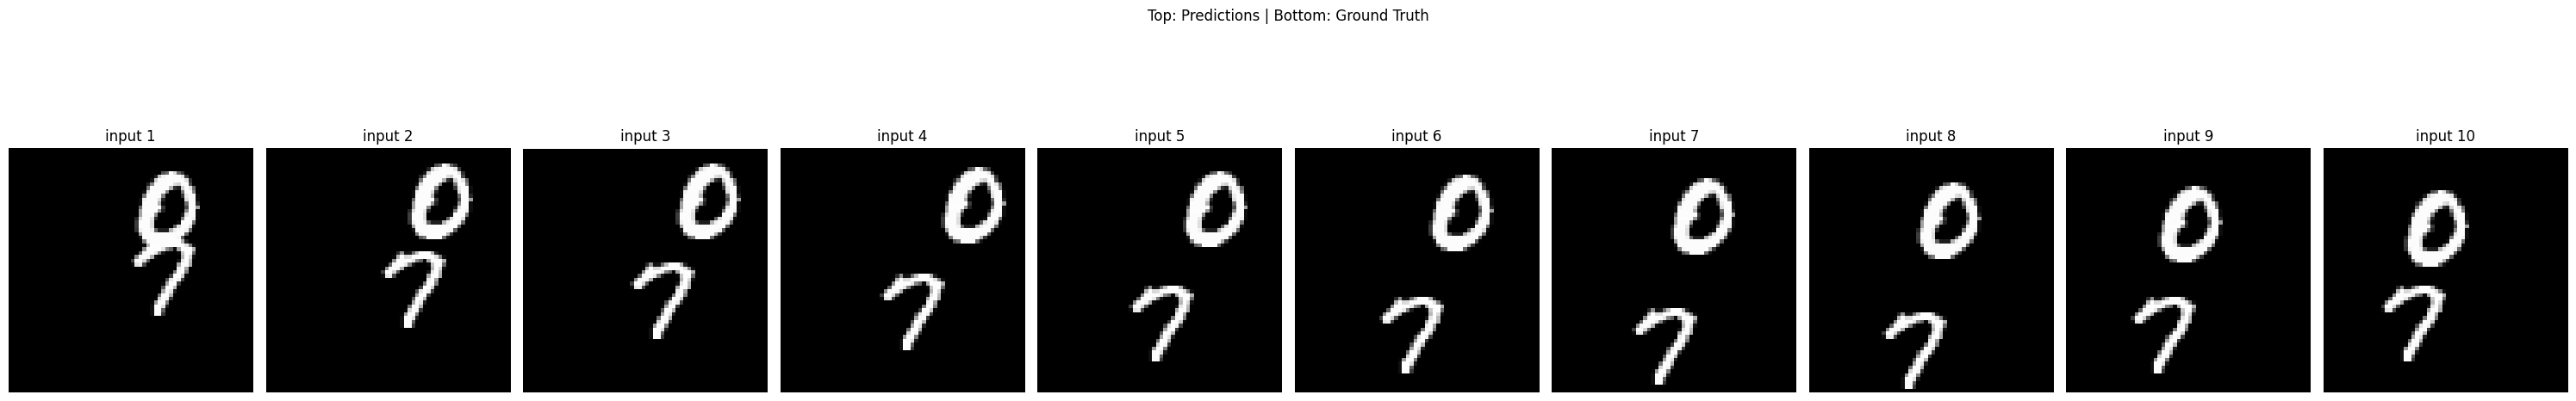

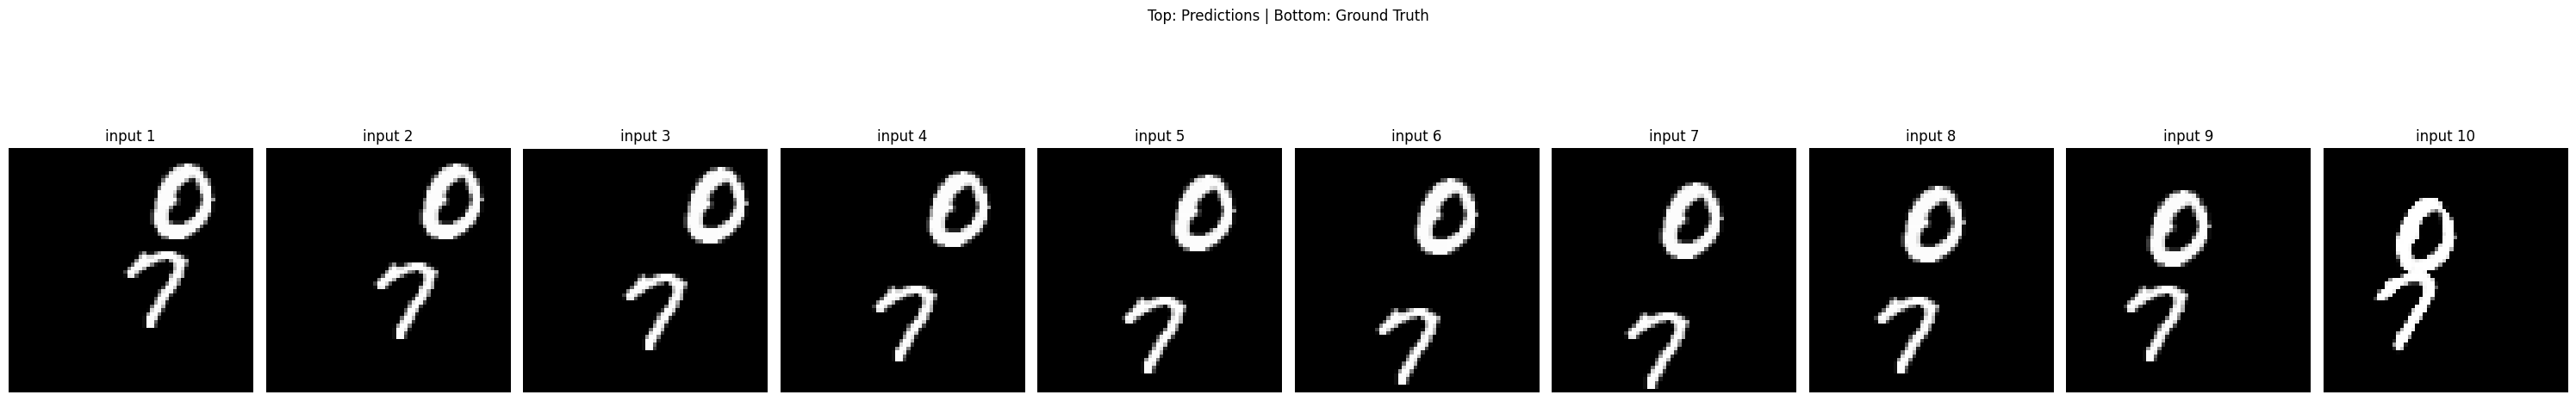

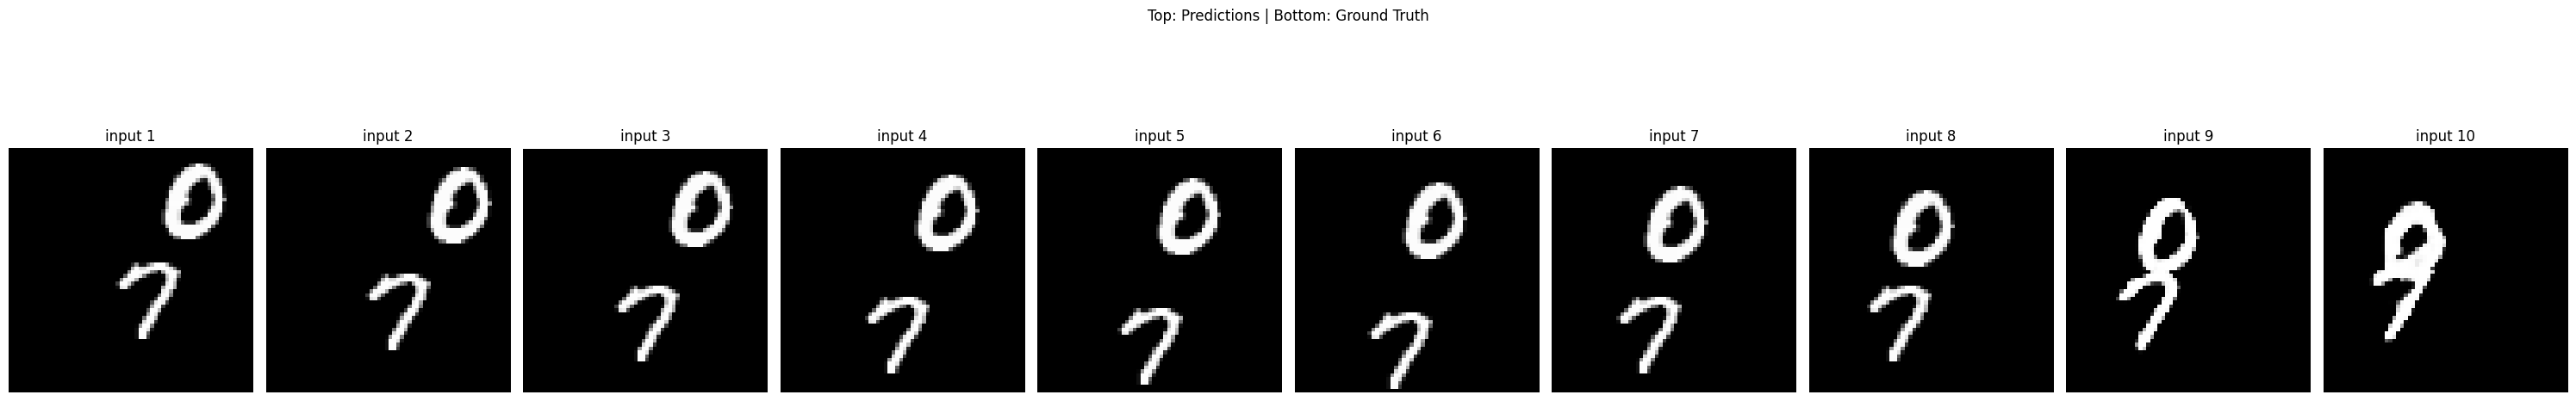

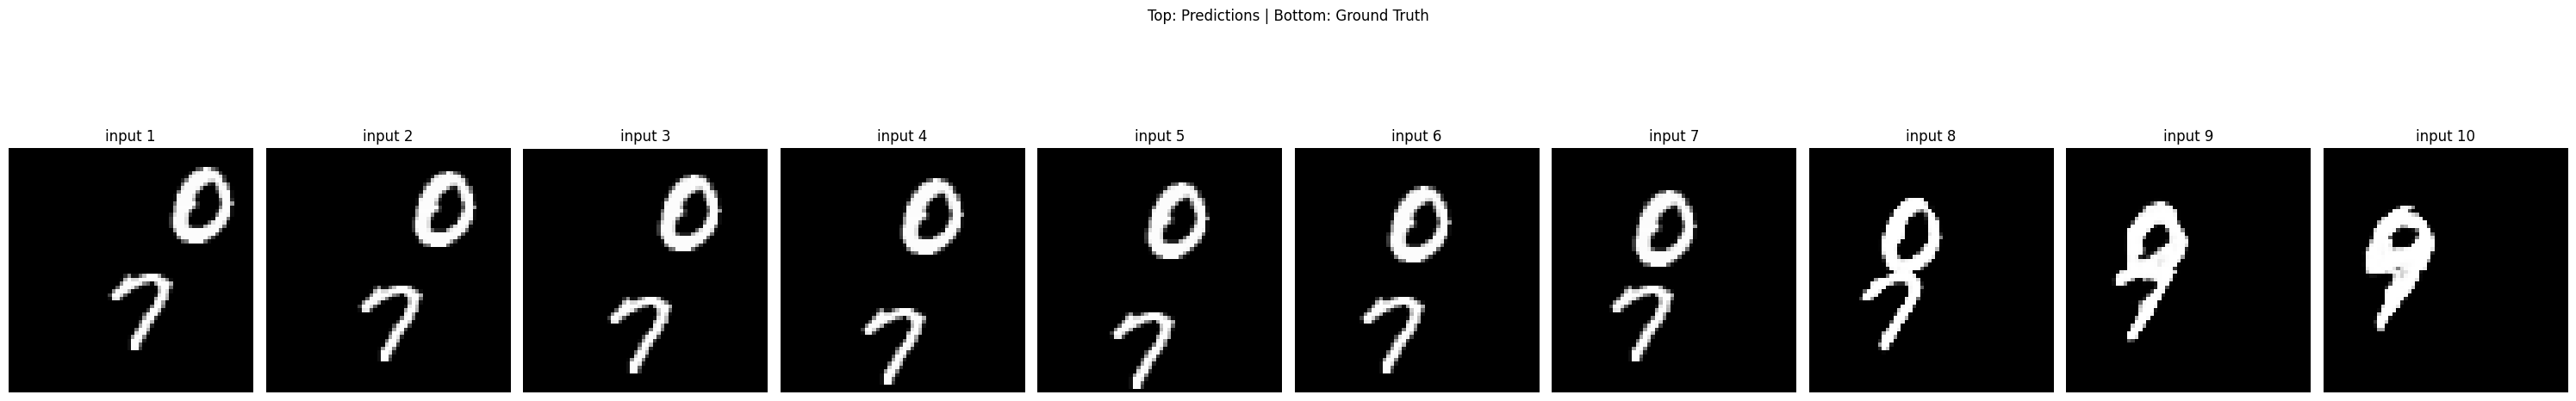

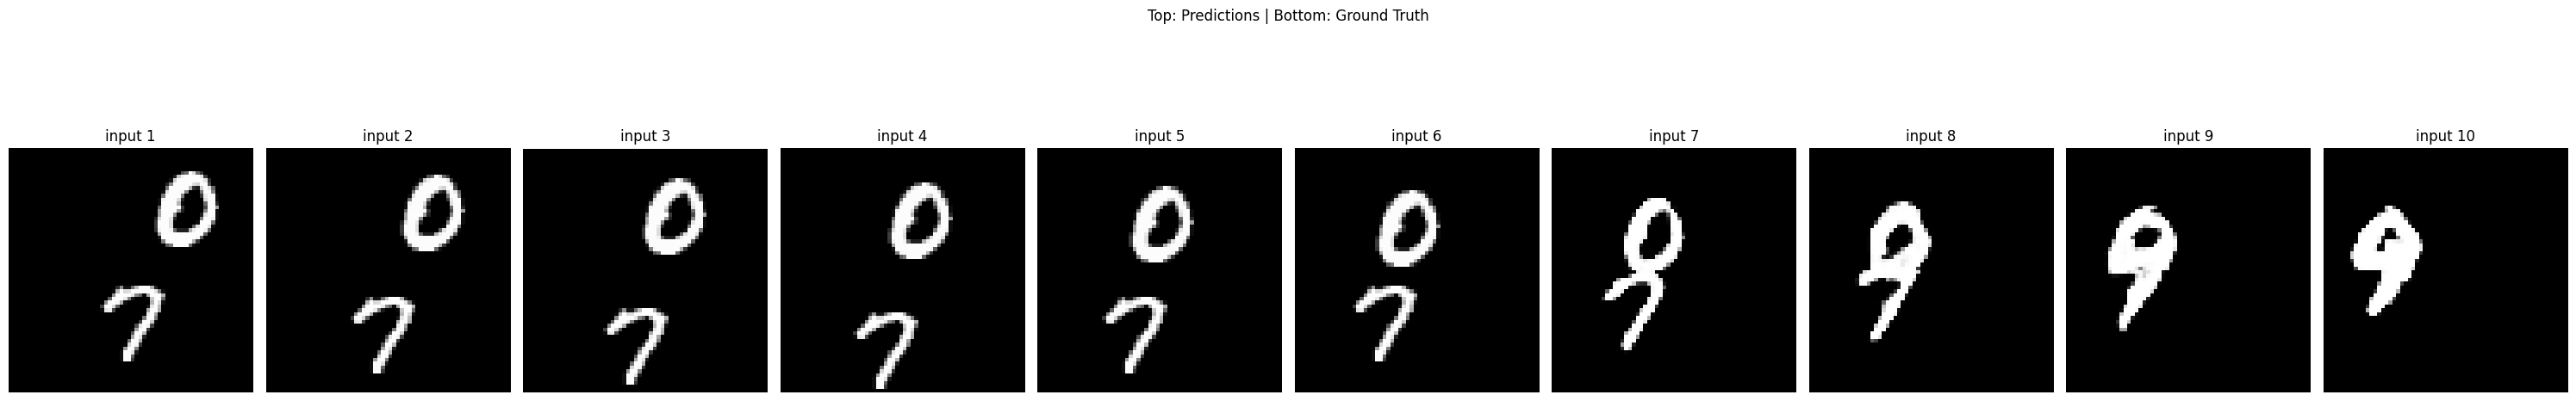

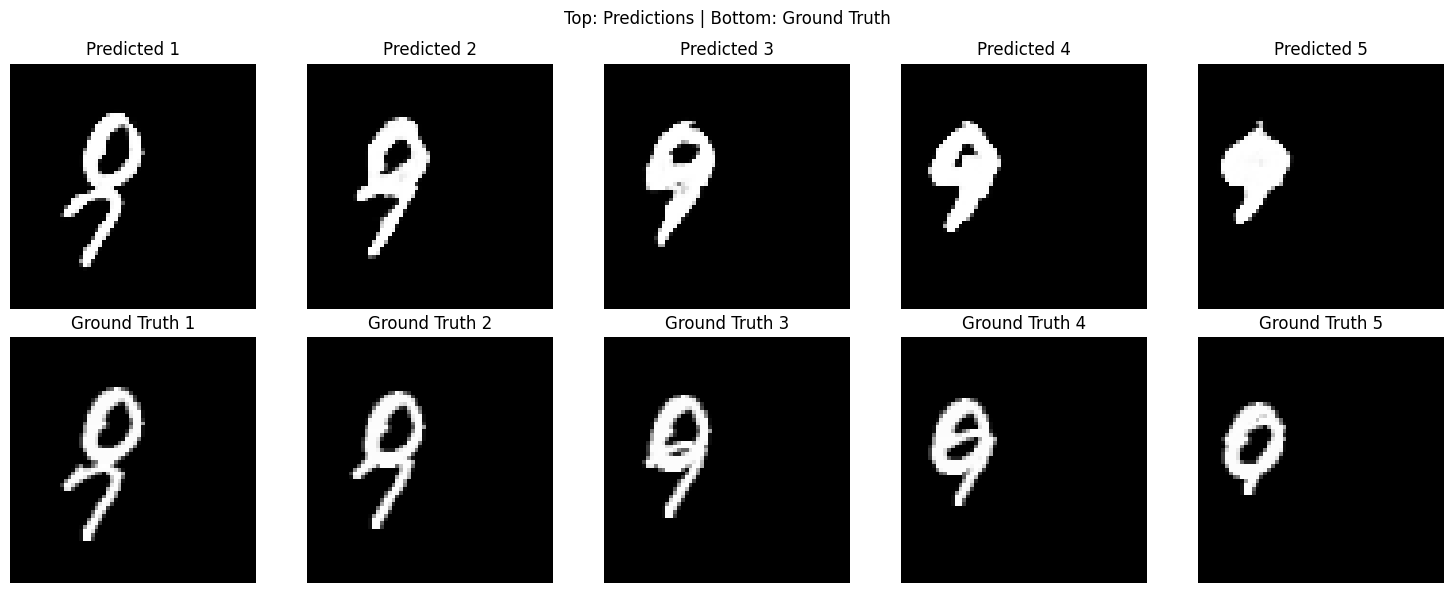

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_42.to(device)
dataset_ = MovingMNISTDataset4(data, t=0, seq_len=15)
dataloader_ = DataLoader(dataset_, batch_size=64, shuffle=True)

sample_sequence, _ = dataset_[255]  # shape: (15, 64, 64) if total frames = 15 (10 past + 5 future)
# Split into input and ground truth
input_sequence = sample_sequence[:10]          
ground_truth_frames = sample_sequence[10:15]     
print(input_sequence.shape)
predicted_frames = predict_future_frames(model_42, input_sequence.to(device), ground_truth_frames, num_predictions=5)


In [30]:
from skimage.metrics import structural_similarity as ssim
import torch
from tqdm import tqdm

def evaluate_recursive_prediction(model, dataloader, num_input_frames=10, num_prediction_frames=5):
    model.eval()
    device = next(model.parameters()).device

    total_loss = 0.0
    total_ssim = 0.0
    num_batches = 0

    # criterion = torch.nn.BCELoss()
    criterion = BCEDiceLoss()  
    

    with torch.no_grad():
        for input_sequence, _ in tqdm(dataloader, desc="Evaluating", unit="batch"):
            input_sequence = input_sequence.to(device)  # shape: [B, 20, 64, 64]

            for b in range(input_sequence.size(0)):  # loop through batch
                full_sequence = input_sequence[b]  # shape: [20, 64, 64]
                input_frames = full_sequence[:num_input_frames]  # frames 0–9
                target_frames = full_sequence[num_input_frames:num_input_frames + num_prediction_frames]  # frames 10–14

                current_input = input_frames.unsqueeze(0)  # shape: [1, 10, 64, 64]

                predicted_frames = []

                for i in range(num_prediction_frames):
                    output = model(current_input)  # shape: [1, 1, 64, 64]
                    predicted_frame = output.detach()

                    predicted_frames.append(predicted_frame.squeeze(0).squeeze(0))  # shape: [64, 64]

                    # Update current input: remove first frame, add predicted frame
                    current_input = torch.cat((current_input[:, 1:], predicted_frame), dim=1)

                # Evaluate predicted frames vs ground truth (frames 10–14)
                for i in range(num_prediction_frames):
                    pred_img = predicted_frames[i].cpu().numpy()
                    true_img = target_frames[i].cpu().numpy()

                    h, w = pred_img.shape
                    win_size = min(h, w)
                    if win_size % 2 == 0:
                        win_size -= 1

                    total_ssim += ssim(pred_img, true_img, data_range=1.0, win_size=win_size)
                    loss = criterion(predicted_frames[i].unsqueeze(0).unsqueeze(0).to(device), 
                                     target_frames[i].unsqueeze(0).unsqueeze(0).to(device))
                    total_loss += loss.item()
                    num_batches += 1

    avg_loss = total_loss / num_batches
    avg_ssim = total_ssim / num_batches

    print(f"\n🧪 Average Recursive Prediction Loss: {avg_loss:.4f}")
    print(f"📷 Average Recursive Prediction SSIM: {avg_ssim:.4f}")


In [31]:
dataset_ = MovingMNISTDataset4(data, t=0, seq_len=15)
dataloader_ = DataLoader(dataset_, batch_size=64, shuffle=True)
evaluate_recursive_prediction(model_42, dataloader_, num_input_frames=10, num_prediction_frames=5)


Evaluating: 100%|██████████| 157/157 [03:32<00:00,  1.35s/batch]


🧪 Average Recursive Prediction Loss: 0.6044
📷 Average Recursive Prediction SSIM: 0.6438


# Scheduled Sampling: Training + Evaluation: predicted as input

In [18]:
class MovingMNISTDataset4(Dataset):
    def __init__(self, data, t=0, seq_len=10):
        self.data = data
        self.t = t
        self.seq_len = seq_len

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        input_frames = self.data[idx, self.t:self.t + self.seq_len]        # frames t to t+9
        target_frame = self.data[idx, self.t + self.seq_len]               # frame t+10
        input_tensor = torch.tensor(input_frames, dtype=torch.float32)     # shape (10, 64, 64)
        target_tensor = torch.tensor(target_frame, dtype=torch.float32).unsqueeze(0)
        return input_tensor, target_tensor
class VanillaCNN4(nn.Module):
    def __init__(self):
        super(VanillaCNN4, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(10, 32, 3, padding=1), nn.ReLU(),  
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
class ResNet18_v4(nn.Module):
    def __init__(self):
        super(ResNet18_v4, self).__init__()
        resnet = models.resnet18(weights=None)  
        self.encoder = resnet
        
        self.encoder.conv1 = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.encoder = nn.Sequential(
            self.encoder.conv1,
            self.encoder.bn1,
            self.encoder.relu,
            self.encoder.maxpool,
            self.encoder.layer1,
            self.encoder.layer2,
            self.encoder.layer3,
            self.encoder.layer4
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2), nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.encoder(x)           
        x = self.decoder(x)
        return x



In [15]:
num_input_frames = 10
num_prediction_frames = 5

dataset4 = MovingMNISTDataset4(data, t=0, seq_len=num_input_frames + num_prediction_frames)
dataloader = DataLoader(dataset4, batch_size=64, shuffle=True)


In [16]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_with_scheduled_sampling(model, dataloader, optimizer, criterion,
                                   epoch, total_epochs,
                                   dataset=None,  # <-- Added
                                   visualize_every=5,
                                   num_input_frames=10, num_prediction_frames=5,
                                   device='cuda'):
    model.train()
    total_loss = 0.0
    num_batches = 0

    teacher_forcing_prob = max(0.0, 1.0 - epoch / total_epochs)

    for input_sequence, _ in tqdm(dataloader, desc=f"Training (Epoch {epoch})", unit="batch"):
        input_sequence = input_sequence.to(device)
        optimizer.zero_grad()
        batch_loss = 0.0

        input_frames = input_sequence[:, :num_input_frames]
        target_frames = input_sequence[:, num_input_frames:num_input_frames + num_prediction_frames]
        
        current_input = input_frames.clone()

        for i in range(num_prediction_frames):
            output = model(current_input)
            true_frame = target_frames[:, i].unsqueeze(1)
            loss = criterion(output, true_frame)
            batch_loss += loss

            use_ground_truth = torch.rand(current_input.size(0), device=device) < teacher_forcing_prob
            next_input_frame = torch.where(use_ground_truth.view(-1, 1, 1, 1), true_frame, output.detach())
            current_input = torch.cat((current_input[:, 1:], next_input_frame), dim=1)

        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    print(f"\n📉 Avg Scheduled Sampling Loss (Epoch {epoch}): {avg_loss:.4f} | TF prob: {teacher_forcing_prob:.2f}")

    # --- VISUALIZE ---
    if dataset is not None and epoch % visualize_every == 0:
        model.eval()
        with torch.no_grad():
            sample_idx = random.randint(0, len(dataset)-1)
            sample_sequence, _ = dataset[sample_idx]
            input_seq = sample_sequence[:num_input_frames].unsqueeze(0).to(device)
            ground_truth = sample_sequence[num_input_frames:num_input_frames+num_prediction_frames]

            predictions = []

            for _ in range(num_prediction_frames):
                output = model(input_seq)
                predictions.append(output.squeeze(0).squeeze(0).cpu())
                input_seq = torch.cat((input_seq[:, 1:], output), dim=1)

            # Plot
            fig, axes = plt.subplots(2, num_prediction_frames, figsize=(3*num_prediction_frames, 6))
            for i in range(num_prediction_frames):
                axes[0, i].imshow(predictions[i], cmap='gray')
                axes[0, i].set_title(f"Predicted {i+1}")
                axes[0, i].axis('off')

                axes[1, i].imshow(ground_truth[i], cmap='gray')
                axes[1, i].set_title(f"Ground Truth {i+1}")
                axes[1, i].axis('off')

            plt.suptitle(f"Epoch {epoch}: Top = Prediction | Bottom = Ground Truth")
            plt.tight_layout()
            plt.show()


Training (Epoch 0): 100%|██████████| 157/157 [00:25<00:00,  6.21batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 0): 3.9237 | TF prob: 1.00


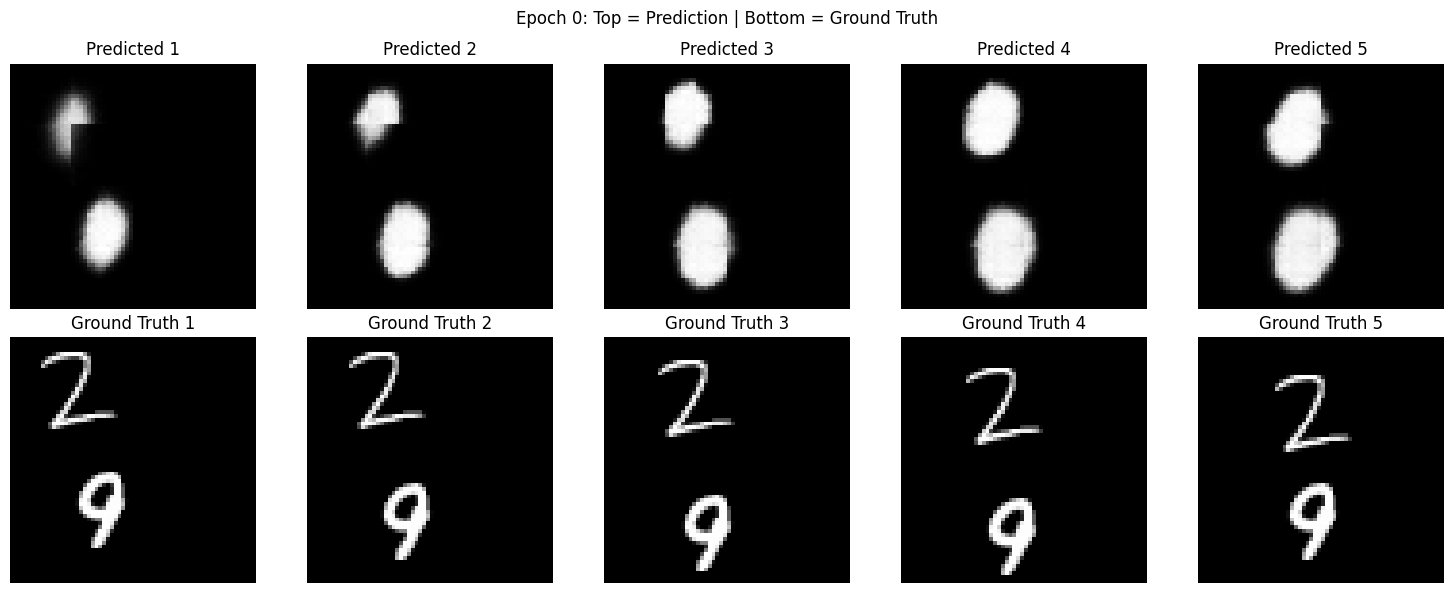

Training (Epoch 1): 100%|██████████| 157/157 [00:25<00:00,  6.15batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 1): 2.8477 | TF prob: 0.97


Training (Epoch 2): 100%|██████████| 157/157 [00:26<00:00,  6.01batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 2): 2.6335 | TF prob: 0.93


Training (Epoch 3): 100%|██████████| 157/157 [00:25<00:00,  6.17batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 3): 2.4692 | TF prob: 0.90


Training (Epoch 4): 100%|██████████| 157/157 [00:25<00:00,  6.19batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 4): 2.3467 | TF prob: 0.87


Training (Epoch 5): 100%|██████████| 157/157 [00:25<00:00,  6.18batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 5): 2.2519 | TF prob: 0.83


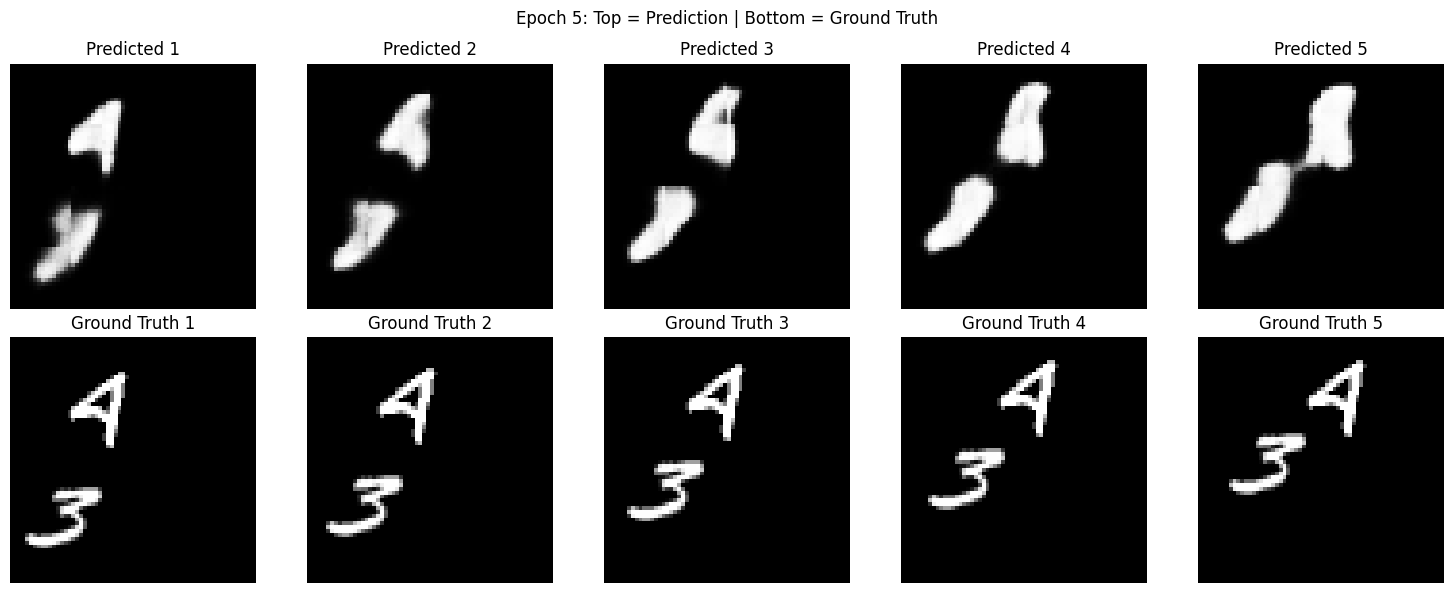

Training (Epoch 6): 100%|██████████| 157/157 [00:25<00:00,  6.14batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 6): 2.1848 | TF prob: 0.80


Training (Epoch 7): 100%|██████████| 157/157 [00:25<00:00,  6.17batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 7): 2.1323 | TF prob: 0.77


Training (Epoch 8): 100%|██████████| 157/157 [00:25<00:00,  6.16batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 8): 2.0834 | TF prob: 0.73


Training (Epoch 9): 100%|██████████| 157/157 [00:25<00:00,  6.18batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 9): 2.0516 | TF prob: 0.70


Training (Epoch 10): 100%|██████████| 157/157 [00:25<00:00,  6.19batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 10): 2.0150 | TF prob: 0.67


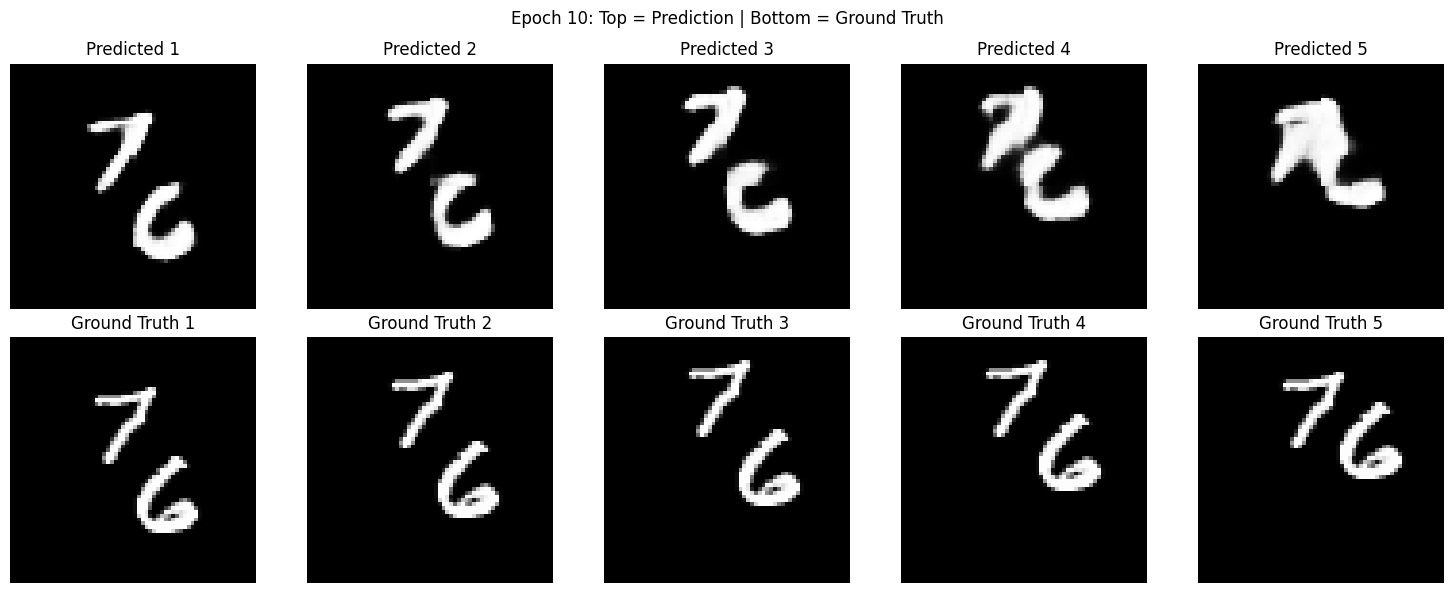

Training (Epoch 11): 100%|██████████| 157/157 [00:25<00:00,  6.20batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 11): 1.9868 | TF prob: 0.63


Training (Epoch 12): 100%|██████████| 157/157 [00:25<00:00,  6.18batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 12): 1.9684 | TF prob: 0.60


Training (Epoch 13): 100%|██████████| 157/157 [00:25<00:00,  6.17batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 13): 1.9569 | TF prob: 0.57


Training (Epoch 14): 100%|██████████| 157/157 [00:25<00:00,  6.17batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 14): 1.9274 | TF prob: 0.53


Training (Epoch 15): 100%|██████████| 157/157 [00:25<00:00,  6.18batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 15): 1.9113 | TF prob: 0.50


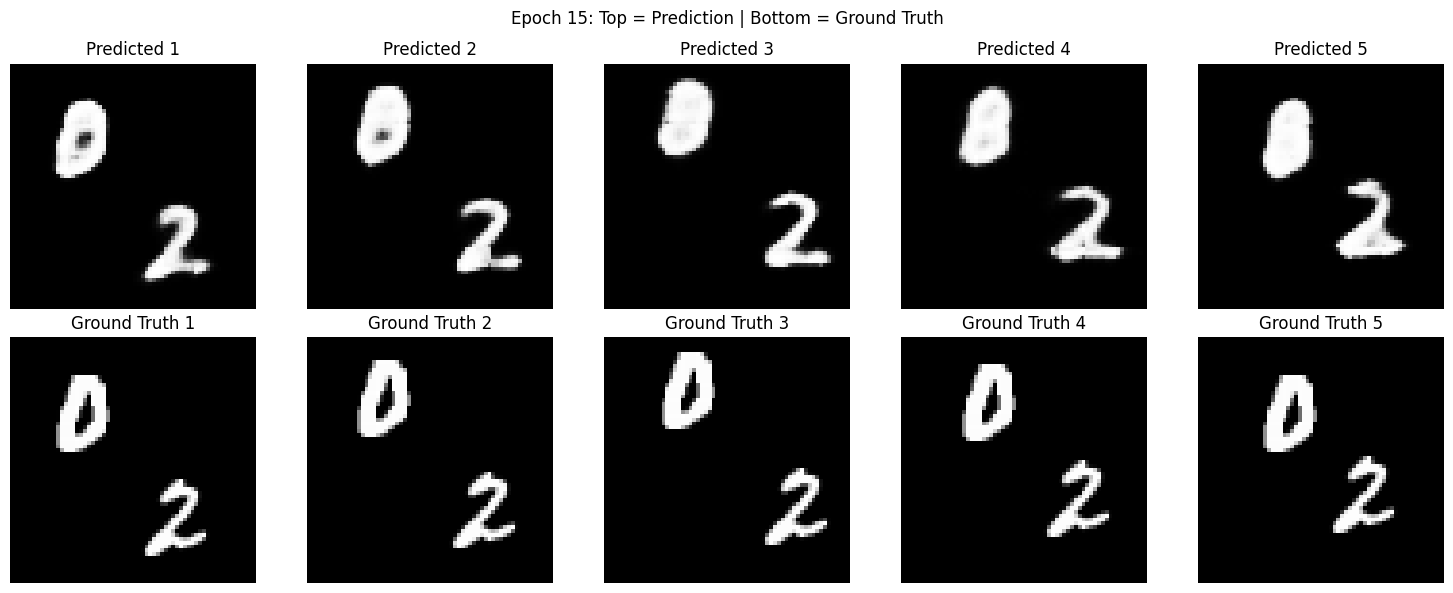

Training (Epoch 16): 100%|██████████| 157/157 [00:25<00:00,  6.18batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 16): 1.9027 | TF prob: 0.47


Training (Epoch 17): 100%|██████████| 157/157 [00:25<00:00,  6.17batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 17): 1.9170 | TF prob: 0.43


Training (Epoch 18): 100%|██████████| 157/157 [00:25<00:00,  6.17batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 18): 1.8834 | TF prob: 0.40


Training (Epoch 19): 100%|██████████| 157/157 [00:25<00:00,  6.17batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 19): 1.8946 | TF prob: 0.37


Training (Epoch 20): 100%|██████████| 157/157 [00:25<00:00,  6.17batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 20): 1.8753 | TF prob: 0.33


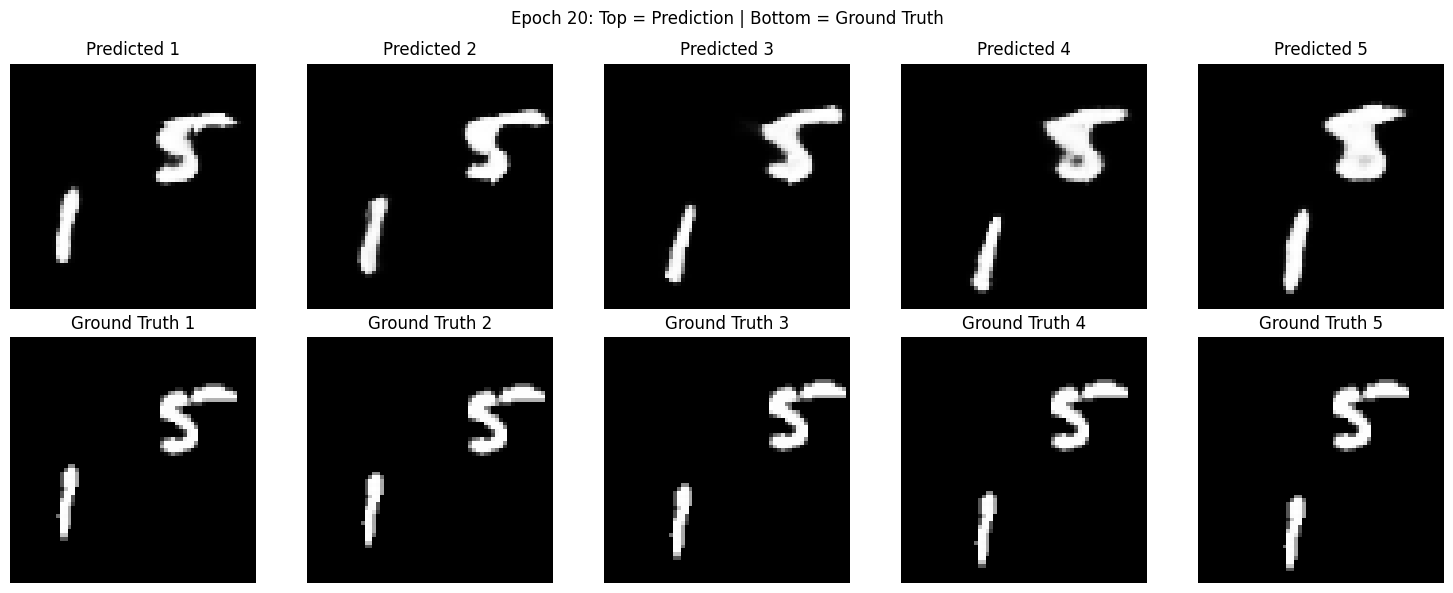

Training (Epoch 21): 100%|██████████| 157/157 [00:25<00:00,  6.19batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 21): 1.8823 | TF prob: 0.30


Training (Epoch 22): 100%|██████████| 157/157 [00:25<00:00,  6.18batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 22): 1.8683 | TF prob: 0.27


Training (Epoch 23): 100%|██████████| 157/157 [00:25<00:00,  6.18batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 23): 1.8789 | TF prob: 0.23


Training (Epoch 24): 100%|██████████| 157/157 [00:25<00:00,  6.18batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 24): 1.8860 | TF prob: 0.20


Training (Epoch 25): 100%|██████████| 157/157 [00:25<00:00,  6.17batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 25): 1.8748 | TF prob: 0.17


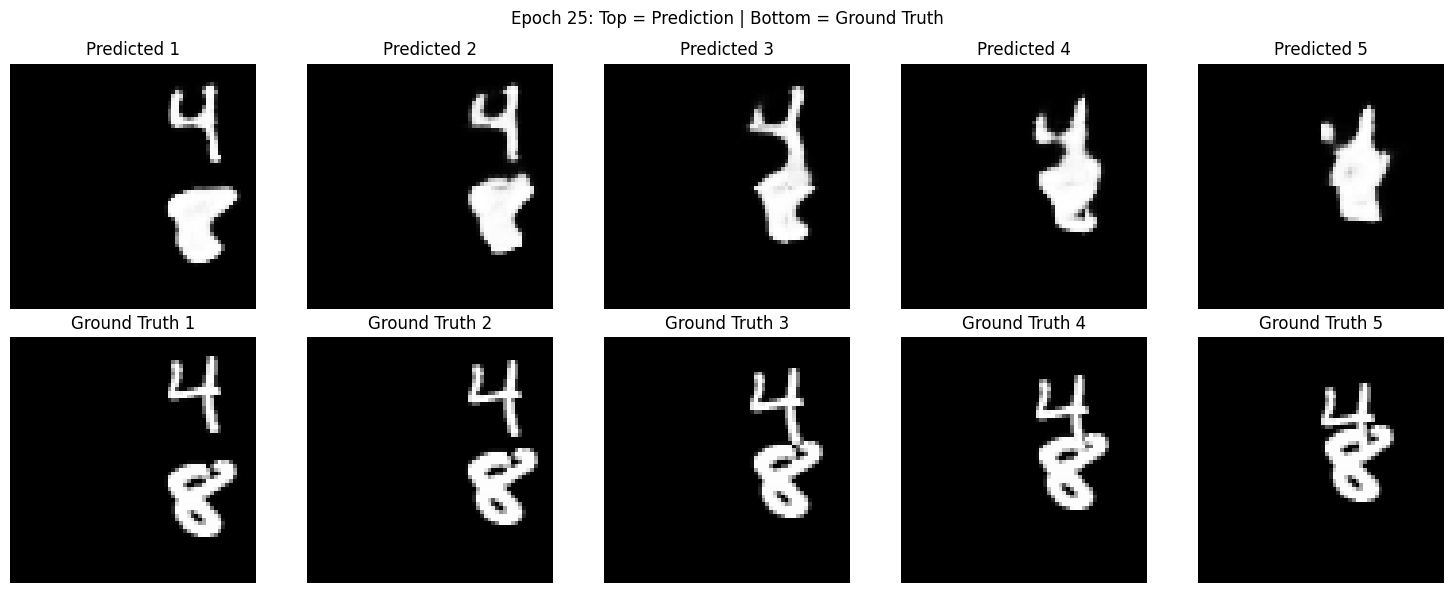

Training (Epoch 26): 100%|██████████| 157/157 [00:25<00:00,  6.20batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 26): 1.8620 | TF prob: 0.13


Training (Epoch 27): 100%|██████████| 157/157 [00:25<00:00,  6.17batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 27): 1.8666 | TF prob: 0.10


Training (Epoch 28): 100%|██████████| 157/157 [00:25<00:00,  6.18batch/s]



📉 Avg Scheduled Sampling Loss (Epoch 28): 1.8745 | TF prob: 0.07


Training (Epoch 29): 100%|██████████| 157/157 [00:25<00:00,  6.18batch/s]


📉 Avg Scheduled Sampling Loss (Epoch 29): 1.8650 | TF prob: 0.03


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_43 = ResNet18_v4()
model_43 = model_43.to(device)
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - ((2. * intersection + 1) / (inputs.sum() + targets.sum() + 1))
        return bce_loss + dice_loss
# criterion = nn.BCELoss() 

criterion = BCEDiceLoss()  
optimizer = optim.Adam(model_43.parameters(), lr=0.001)
total_epochs = 30

for epoch in range(total_epochs):
    train_with_scheduled_sampling(model_43, dataloader, optimizer, criterion,
                                  epoch=epoch,
                                  total_epochs=total_epochs,
                                  dataset=dataset4,
                                  visualize_every=5,  # Show prediction every 5 epochs
                                  device='cuda')


In [20]:
import torch
import matplotlib.pyplot as plt

def predict_future_frames(model, input_sequence, ground_truth_frames, num_predictions=5):
    """
    Predicts next `num_predictions` frames and visualizes them alongside ground truth.
    """
    model.eval() 
    predicted_frames = []

    current_input = input_sequence.clone().unsqueeze(0)  # shape: (1, 10, 64, 64)

    for i in range(num_predictions):
        with torch.no_grad():
            current_input = current_input.to(next(model.parameters()).device)
            output = model(current_input)  # Forward pass
            predicted_frame = output.detach() 
        CI=current_input.squeeze(0).squeeze(0).cpu() # For matplotlib
        
        fig, axes = plt.subplots(1, 10, figsize=(3 * 10, 6))
        for i in range(10):
            axes[i].imshow(CI[i], cmap='gray')
            axes[i].set_title(f'input {i+1}')
            axes[i].axis('off')
        plt.suptitle("Top: Predictions | Bottom: Ground Truth")
        plt.tight_layout()
        plt.show()
        
        predicted_frames.append(predicted_frame.squeeze(0).squeeze(0).cpu())  # For matplotlib
        # predicted_frames.append(predicted_frame.squeeze(0).squeeze(0))  # shape: (64, 64)
        current_input = torch.cat((current_input[:, 1:], predicted_frame), dim=1)  # Update input window

    # ---------- Visualization ----------
    fig, axes = plt.subplots(2, num_predictions, figsize=(3 * num_predictions, 6))

    for i in range(num_predictions):
        # Predicted frame
        axes[0, i].imshow(predicted_frames[i], cmap='gray')
        axes[0, i].set_title(f'Predicted {i+1}')
        axes[0, i].axis('off')

        # Ground truth frame
        axes[1, i].imshow(ground_truth_frames[i], cmap='gray')
        axes[1, i].set_title(f'Ground Truth {i+1}')
        axes[1, i].axis('off')

    plt.suptitle("Top: Predictions | Bottom: Ground Truth")
    plt.tight_layout()
    plt.show()

    return predicted_frames


torch.Size([10, 64, 64])


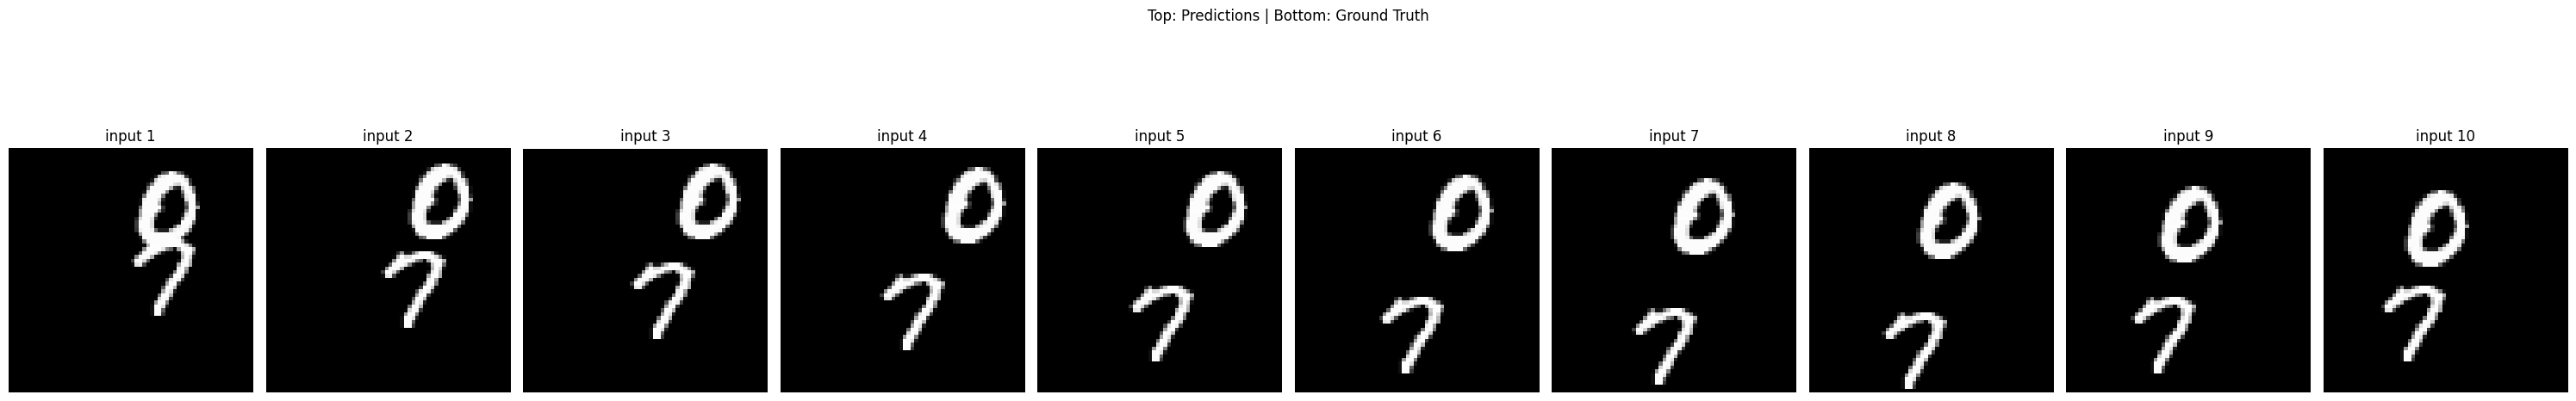

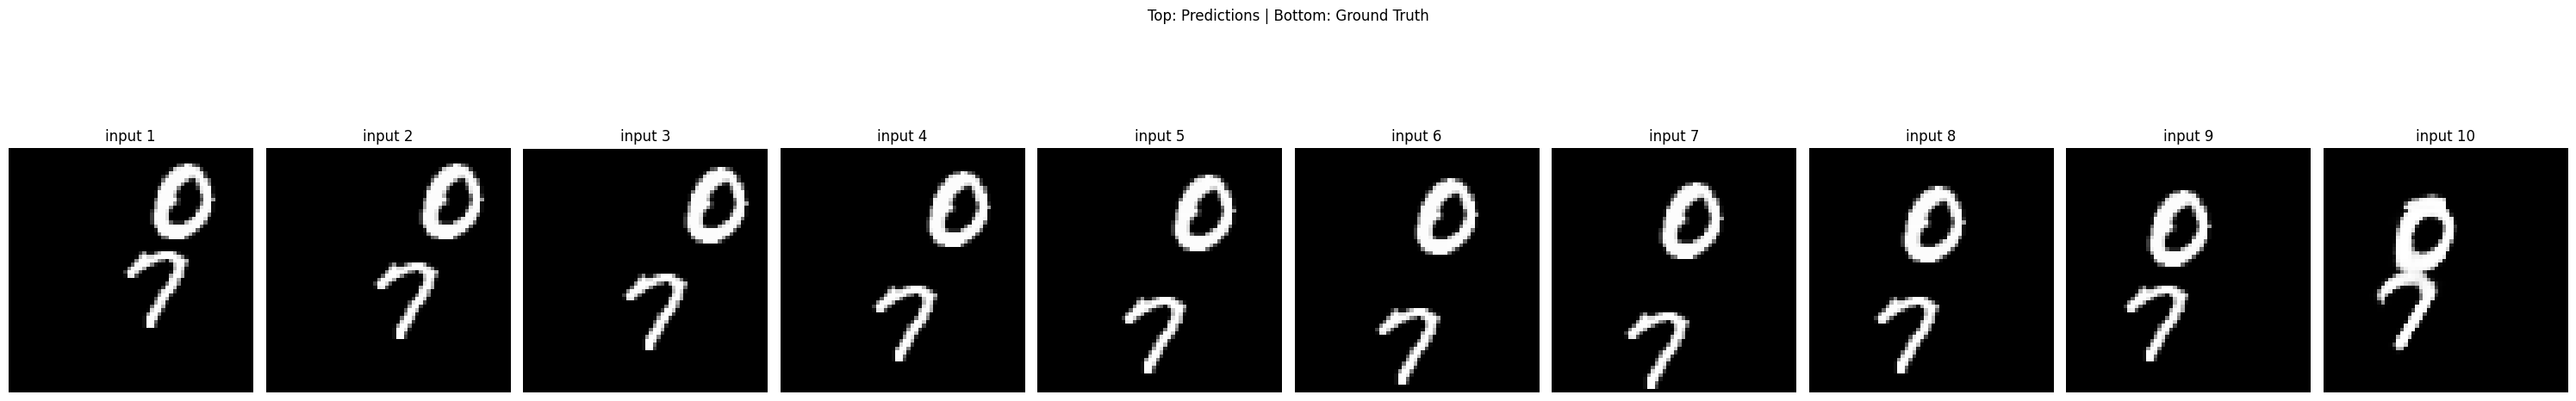

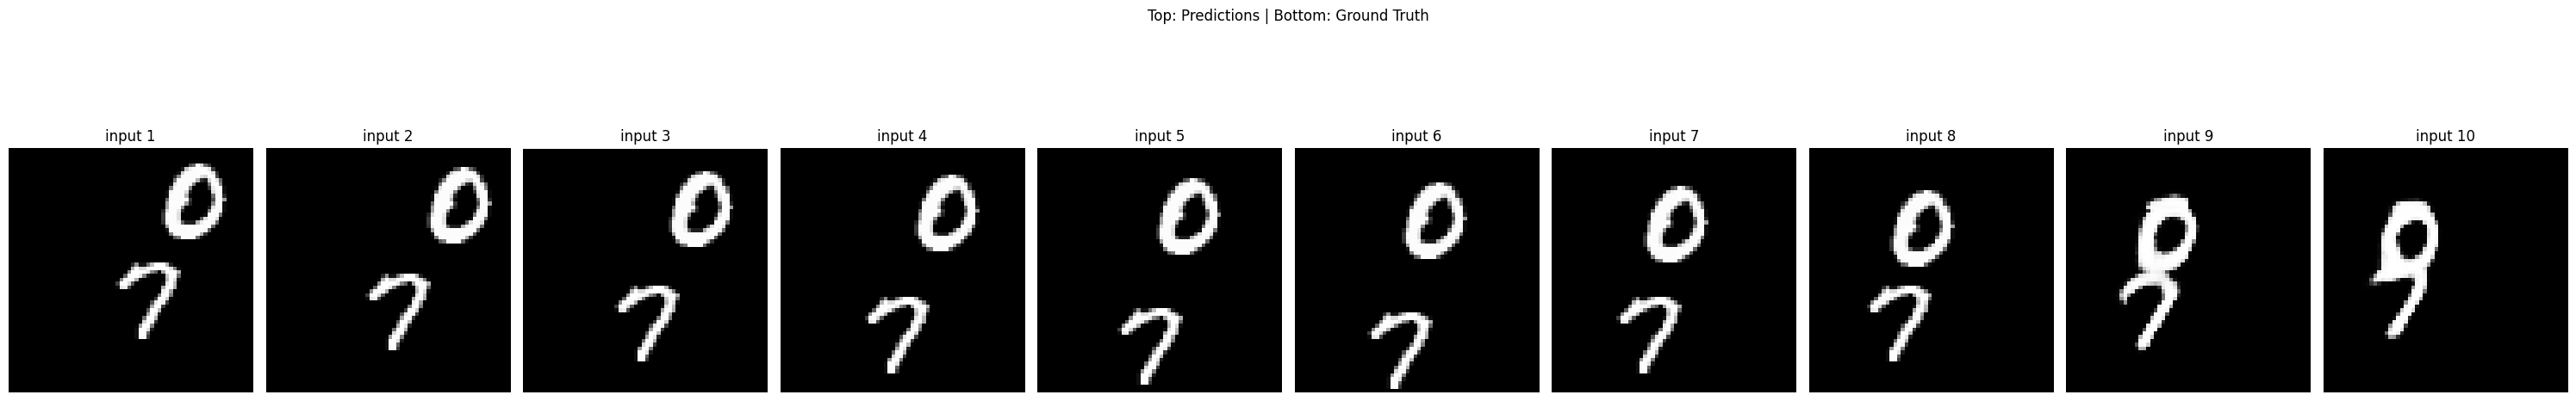

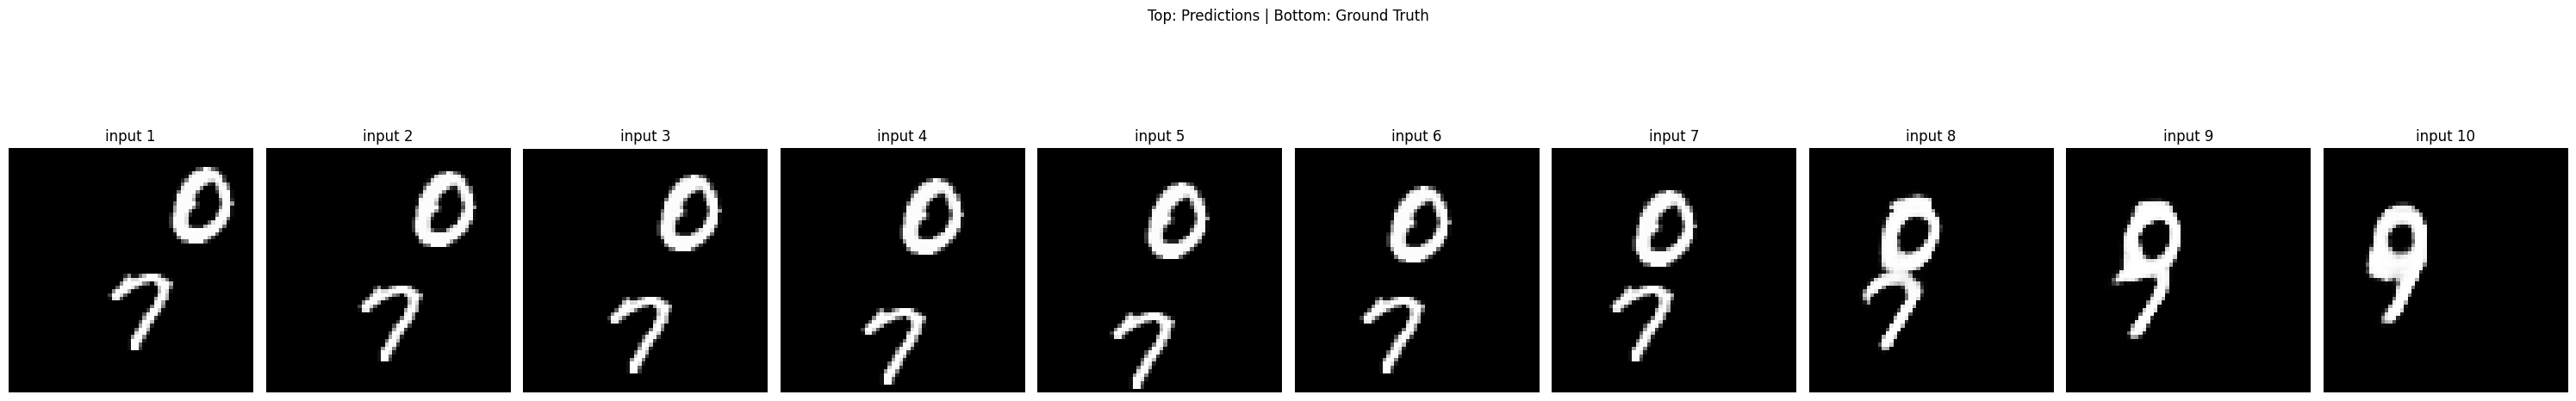

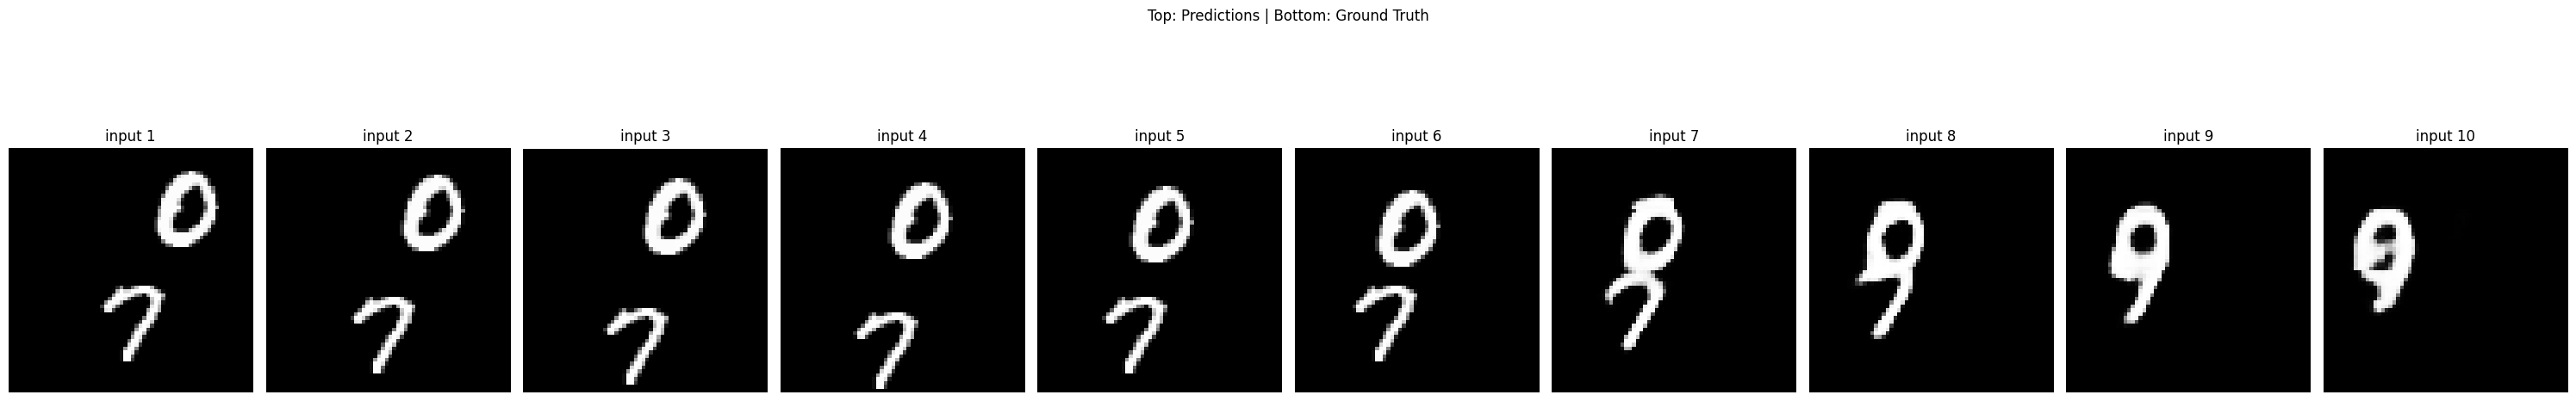

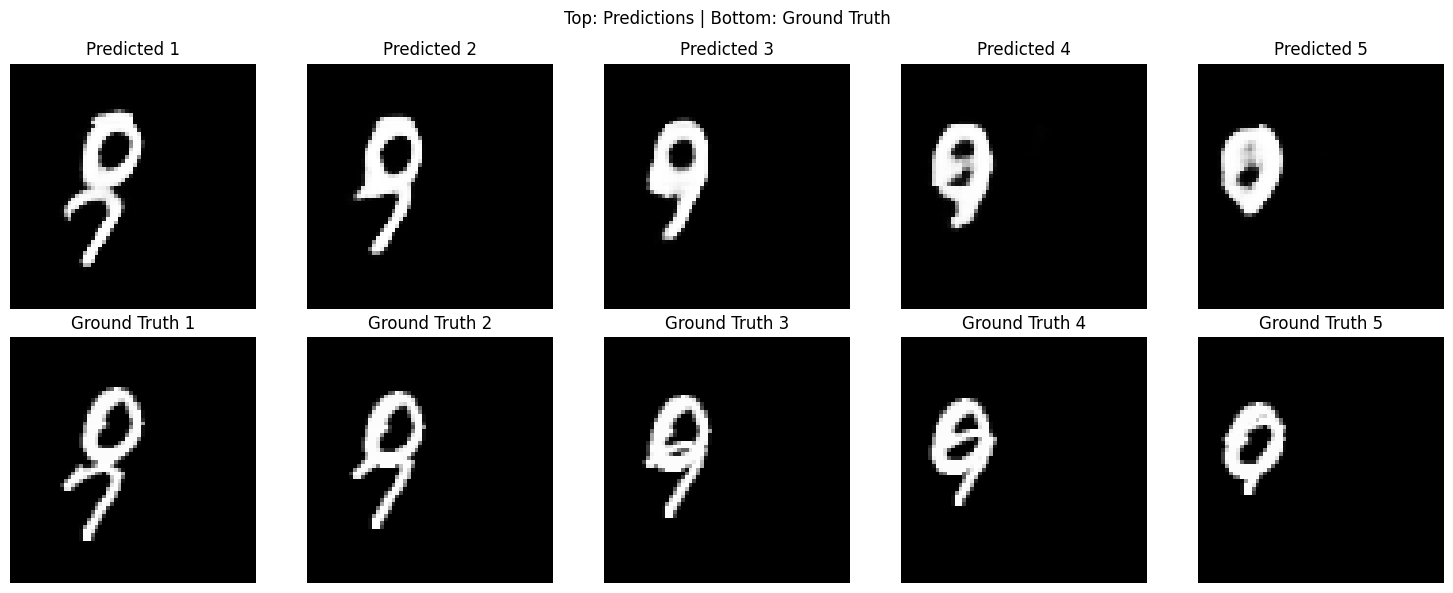

In [21]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_43.to(device)

sample_sequence, _ = dataset4[255]  # shape: (15, 64, 64) if total frames = 15 (10 past + 5 future)
# Split into input and ground truth
input_sequence = sample_sequence[:10]          
ground_truth_frames = sample_sequence[10:15] 

print(input_sequence.shape)
predicted_frames = predict_future_frames(model_43, input_sequence.to(device), ground_truth_frames, num_predictions=5)

In [22]:
from skimage.metrics import structural_similarity as ssim
import torch
from tqdm import tqdm

def evaluate_recursive_prediction(model, dataloader, num_input_frames=10, num_prediction_frames=5):
    model.eval()
    device = next(model.parameters()).device

    total_loss = 0.0
    total_ssim = 0.0
    num_batches = 0

    # criterion = torch.nn.BCELoss()
    criterion = BCEDiceLoss()  
    

    with torch.no_grad():
        for input_sequence, _ in tqdm(dataloader, desc="Evaluating", unit="batch"):
            input_sequence = input_sequence.to(device)  # shape: [B, 20, 64, 64]

            for b in range(input_sequence.size(0)):  # loop through batch
                full_sequence = input_sequence[b]  # shape: [20, 64, 64]
                input_frames = full_sequence[:num_input_frames]  # frames 0–9
                target_frames = full_sequence[num_input_frames:num_input_frames + num_prediction_frames]  # frames 10–14

                current_input = input_frames.unsqueeze(0)  # shape: [1, 10, 64, 64]

                predicted_frames = []

                for i in range(num_prediction_frames):
                    output = model(current_input)  # shape: [1, 1, 64, 64]
                    predicted_frame = output.detach()

                    predicted_frames.append(predicted_frame.squeeze(0).squeeze(0))  # shape: [64, 64]

                    # Update current input: remove first frame, add predicted frame
                    current_input = torch.cat((current_input[:, 1:], predicted_frame), dim=1)

                # Evaluate predicted frames vs ground truth (frames 10–14)
                for i in range(num_prediction_frames):
                    pred_img = predicted_frames[i].cpu().numpy()
                    true_img = target_frames[i].cpu().numpy()

                    h, w = pred_img.shape
                    win_size = min(h, w)
                    if win_size % 2 == 0:
                        win_size -= 1

                    total_ssim += ssim(pred_img, true_img, data_range=1.0, win_size=win_size)
                    loss = criterion(predicted_frames[i].unsqueeze(0).unsqueeze(0).to(device), 
                                     target_frames[i].unsqueeze(0).unsqueeze(0).to(device))
                    total_loss += loss.item()
                    num_batches += 1

    avg_loss = total_loss / num_batches
    avg_ssim = total_ssim / num_batches

    print(f"\n🧪 Average Recursive Prediction Loss: {avg_loss:.4f}")
    print(f"📷 Average Recursive Prediction SSIM: {avg_ssim:.4f}")


In [23]:
evaluate_recursive_prediction(model_43, dataloader, num_input_frames=10, num_prediction_frames=5)


Evaluating: 100%|██████████| 157/157 [03:27<00:00,  1.32s/batch]


🧪 Average Recursive Prediction Loss: 0.4003
📷 Average Recursive Prediction SSIM: 0.7796
